# TIMIT Test split performance analysis
This analyzes model performance on the test split TIMIT corpus, with special attention to performance on vowels. Reduction to the shared Buckeye/TIMIT symbol set is performed before analysis and performance metrics are calculated.

In [1]:
from collections import Counter, defaultdict
from pathlib import Path
from typing import Any

import datasets
import matplotlib
import matplotlib.pyplot as plt
from phonecodes import phonecodes, phonecode_tables
import pandas as pd
import seaborn as sns


import multipa.evaluation
import multipa.evaluation_extras
import multipa.visualization

# Visualiation settings
PALETTE = "gist_gray"
CONTEXT = "paper"
FONT_SCALE = 2

sns.color_palette(PALETTE)
sns.set_context(context=CONTEXT, font_scale=FONT_SCALE)
# font = {"size": 16}
# matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None

VIZ_OUTPUT_DIR = Path("../paper_viz")
VIZ_OUTPUT_DIR.mkdir(exist_ok=True)

/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data processing settings
TIMIT_DATASET = Path("../../data/TIMIT")
IPA_KEY = "ipa"
PREDICTION_KEY = "prediction"
MODEL_KEY = "model"
MODEL_NAME_KEY = "model_name"
MODEL_SOURCE_KEY = "Model source"
NUM_PROC = 8

# Evaluation results
TIMIT_EVAL_DIR = Path("../../data/timit_results/")

DETAILED_PRED_DIR = TIMIT_EVAL_DIR / "detailed_predictions"
EDIT_DIST_DIR = TIMIT_EVAL_DIR / "edit_distances"

FULL_RESULTS_OUT = "timit_detailed_eval_post_processing.csv"
AGGREGATE_RESULTS_OUT = "timit_aggregate_post_processing.csv"

# Full original set, some may be removed after symbol reduction
TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɹ̩", "ɚ"]
TIMIT_DIPHTHONGS = ["aʊ", "eɪ", "aɪ",  "oʊ", "ɔɪ"]

DIALECT_REGIONS = {
    "DR1": "DR1: New England",
    "DR2": "DR2: Northern",
    "DR3": "DR3: North Midland",
    "DR4": "DR4: South Midland",
    "DR5": "DR5: Southern",
    "DR6": "DR6: New York City",
    "DR7": "DR7: Western",
    "DR8": "DR8: Army Brat"
}




## Basic model performance comparisons
Show performance metrics for each model on TIMIT. 

In [3]:
# Manually define and join model source description
OUR_BEST_MODEL = "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa"

# Models fine-tuned on Buckeye, post process using BUCKEYE_REDUCED_MAPPING
WAV2IPA_MODELS = [
    ("ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa", "Buckeye fine-tuned on full train split"),
    ("ginic/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3", "Lee 2025 fine-tuned again on Buckeye"),
    ]

# External models, post process using
EXTERNAL_MODELS = [
    ("excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k", "Lee 2025 Wav2Vec2.0 TIMIT fine-tuned"),
    ("openai_whisper-medium.en_to_epitran", "Whisper + Epitran"),
    ("facebook/wav2vec2-lv-60-espeak-cv-ft", "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    ("allosaurus_eng2102_eng", "Allosaurus English"),
    ("ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns", "Taguchi et al. 2023"),
    # Intentionally omitting Whisper large and xlsr-53 - let's just keep the best in each category
    # ("openai_whisper-large-v3-turbo_to_epitran", "Whisper + Epitran"),
    #("facebook/wav2vec2-xlsr-53-espeak-cv-ft", "facebook/wav2vec2-xlsr-53-espeak-cv-ft"),
]

MODEL_LABEL_LOOKUP = {multipa.evaluation.clean_model_name(model): label for model, label in WAV2IPA_MODELS + EXTERNAL_MODELS}

hue_order = [t[1] for t in WAV2IPA_MODELS + EXTERNAL_MODELS]

model_sources_df = pd.DataFrame(WAV2IPA_MODELS + EXTERNAL_MODELS, columns=[MODEL_KEY, MODEL_SOURCE_KEY])


# Read and preprocess TIMIT test set
Performs symbol reduction on the TIMIT test set.

In [4]:
timit_test_dataset = datasets.load_dataset("timit_asr", data_dir = TIMIT_DATASET, split="test")
print("TIMIT Test Size:", len(timit_test_dataset))
print("TIMIT Test Snippet:", timit_test_dataset[0])
print(timit_test_dataset[0]["phonetic_detail"]["utterance"])

TIMIT Test Size: 1680
TIMIT Test Snippet: {'file': '/Users/virginia/workspace/multipa/data/TIMIT/TEST/DR1/FAKS0/SA1.WAV', 'audio': {'path': '/Users/virginia/workspace/multipa/data/TIMIT/TEST/DR1/FAKS0/SA1.WAV', 'array': array([9.15527344e-05, 1.52587891e-04, 6.10351562e-05, ...,
       2.44140625e-04, 3.05175781e-04, 2.13623047e-04]), 'sampling_rate': 16000}, 'text': 'She had your dark suit in greasy wash water all year.', 'phonetic_detail': {'start': [0, 9640, 11240, 12783, 14078, 16157, 16880, 17103, 17587, 18760, 19720, 19962, 21514, 22680, 23800, 24104, 26280, 28591, 29179, 30337, 31880, 32500, 33170, 33829, 35150, 37370, 38568, 40546, 42357, 45119, 45624, 46855, 48680, 49240, 51033, 52378, 54500, 55461, 57395, 59179, 60600], 'stop': [9640, 11240, 12783, 14078, 16157, 16880, 17103, 17587, 18760, 19720, 19962, 21514, 22680, 23800, 24104, 26280, 28591, 29179, 30337, 31880, 32500, 33170, 33829, 35150, 37370, 38568, 40546, 42357, 45119, 45624, 46855, 48680, 49240, 51033, 52378, 54500, 

In [5]:
def batch_timit_to_ipa(dataset_entry:dict[str, Any]):
    timit_str = dataset_entry["phonetic_detail"]["utterance"]
    ipa_syms = phonecodes.timit2ipa(" ".join(timit_str)).split()
    dataset_entry[IPA_KEY] = "".join(ipa_syms)
    return dataset_entry

In [6]:
# Convert original TIMIT ARPABET to IPA
timit_test_with_ipa = timit_test_dataset.map(batch_timit_to_ipa, num_proc=NUM_PROC)
print(timit_test_with_ipa[0]["phonetic_detail"]["utterance"])
print(timit_test_with_ipa[0][IPA_KEY])

['h#', 'sh', 'iy', 'hv', 'ae', 'dcl', 'd', 'y', 'er', 'dcl', 'd', 'aa', 'r', 'kcl', 'k', 's', 'uw', 'dx', 'ih', 'ng', 'gcl', 'g', 'r', 'iy', 's', 'iy', 'w', 'aa', 'sh', 'epi', 'w', 'aa', 'dx', 'er', 'q', 'ao', 'l', 'y', 'iy', 'axr', 'h#']
ʃiɦædjɝdɑɹksuɾɪŋɡɹisiwɑʃwɑɾɝʔɔljiɚ


In [7]:
# Post process IPA to reduced TIMIT symbol set
timit_test_with_ipa = multipa.evaluation_extras.dataset_reduction_greedy_find_and_replace(timit_test_with_ipa, IPA_KEY, "timit", num_proc=NUM_PROC)
print(timit_test_with_ipa[0][IPA_KEY])


ʃihædjɹ̩dɑɹksuɾɪŋɡɹisiwɑʃwɑɾɹ̩ʔɔljiɹ̩


In [8]:
# Convert to pandas for easier join
timit_test_with_ipa_df = timit_test_with_ipa.select_columns(["file", IPA_KEY]).to_pandas()

# Resolve the path so that we can join with model eval results
timit_test_with_ipa_df["relative_file_path"] = timit_test_with_ipa_df["file"].str.removeprefix(str((TIMIT_DATASET / "TEST").resolve()))

display(timit_test_with_ipa_df.head())


,file,ipa,relative_file_path
0,/Users/virginia/workspace/multipa/data/TIMIT/T...,ʃihædjɹ̩dɑɹksuɾɪŋɡɹisiwɑʃwɑɾɹ̩ʔɔljiɹ̩,/DR1/FAKS0/SA1.WAV
1,/Users/virginia/workspace/multipa/data/TIMIT/T...,doʊnæsmitɪkɛɹiɪnɔɪliɹæɡlaɪkðæt,/DR1/FAKS0/SA2.WAV
2,/Users/virginia/workspace/multipa/data/TIMIT/T...,hɪzkæptɪnwəsθɪnænhæɡɹ̩dɪnɪzbjuɾufl̩butswɹ̩wɔɹn...,/DR1/FAKS0/SI1573.WAV
3,/Users/virginia/workspace/multipa/data/TIMIT/T...,ðɪɹizənzfɹ̩ðɪsdaɪvsimdfulɪʃnaʊ,/DR1/FAKS0/SI2203.WAV
4,/Users/virginia/workspace/multipa/data/TIMIT/T...,pɹ̩dəkʃɪnmeɪfɔlfɑɹbəloʊəkspɪkteɪʃn̩ts,/DR1/FAKS0/SI943.WAV


# Read, postprocess, and evaluate model results
Model results need to be restricted to the TIMIT test set files. They must also be postprocess to the correct symbol reduction. 

In [9]:
def normalize_timit_path(timit_complete_path: str):
    uppered = timit_complete_path.upper()
    return uppered.removeprefix("/COMPLETE")

def diphthong_merge(t1, t2):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1+t2 in TIMIT_DIPHTHONGS:
        return True
    else:
        return False


In [10]:
EVALUATOR = multipa.evaluation.ModelEvaluator(tokenise_options={
        "diphthongs":True,
        "merge":diphthong_merge}
        )

wav2ipa_with_mapping = [(model, label, multipa.evaluation_extras.BUCKEYE_REDUCED_MAPPING) for model, label in WAV2IPA_MODELS]
external_models_with_mapping = [(model, label, multipa.evaluation_extras.TIMIT_AND_OTHER_REDUCED_MAPPING) for model, label in EXTERNAL_MODELS]

all_results_dfs = []
agg_results = []

for model, label, mapping in wav2ipa_with_mapping + external_models_with_mapping:
    model_name = multipa.evaluation.clean_model_name(model)
    print("Processing model:", model_name)
    results_csv = DETAILED_PRED_DIR / f"{model_name}_detailed_predictions.csv"
    model_results_df = pd.read_csv(results_csv, usecols=["filename", "prediction"])
    model_results_df["filename"] = model_results_df["filename"].apply(normalize_timit_path)
    model_results_df[PREDICTION_KEY] = model_results_df[PREDICTION_KEY].apply(lambda x: multipa.evaluation_extras.greedy_reduction_find_and_replace(x, mapping))
    model_results_df[MODEL_KEY] = model
    model_results_df[MODEL_NAME_KEY] = model_name
    model_results_df[MODEL_SOURCE_KEY] = label
    # Inner join on test dataset
    model_results_df = timit_test_with_ipa_df.merge(model_results_df, left_on="relative_file_path", right_on = "filename")
    # Check that there are predictions for all tests data
    assert len(model_results_df) == len(timit_test_with_ipa_df)

    # Calculate metrics and add to dataframe
    metrics = EVALUATOR.eval_non_empty_transcriptions(
        model_name,
        predictions=model_results_df[PREDICTION_KEY],
        references=model_results_df[IPA_KEY],

    )
    mean_metrics_dict = {MODEL_KEY: model, MODEL_NAME_KEY: model_name, MODEL_SOURCE_KEY:label}
    for metric_name, metric_values in metrics.items():
        if metric_name.startswith("mean"):
            mean_metrics_dict[metric_name] = metric_values
        else:
            model_results_df[metric_name] = metric_values

    agg_results.append(mean_metrics_dict)
    all_results_dfs.append(model_results_df)


Processing model: ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
Processing model: ginic_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3
Processing model: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k
Processing model: openai_whisper-medium.en_to_epitran
Processing model: facebook_wav2vec2-lv-60-espeak-cv-ft
Processing model: allosaurus_eng2102_eng
Processing model: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns


In [11]:
aggregate_perf_df = pd.DataFrame(agg_results)
display(aggregate_perf_df)
aggregate_perf_df.to_csv()

,model,model_name,Model source,mean_phone_error_rate,mean_phone_feature_error_rate,mean_feature_error_rate
0,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.158956,2.297098,0.168420
1,ginic/wav2vec2-large-lv60_phoneme-timit_englis...,ginic_wav2vec2-large-lv60_phoneme-timit_englis...,Lee 2025 fine-tuned again on Buckeye,0.141221,2.075570,0.162837
2,excalibur12/wav2vec2-large-lv60_phoneme-timit_...,excalibur12_wav2vec2-large-lv60_phoneme-timit_...,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,0.079362,1.118180,0.119933
3,openai_whisper-medium.en_to_epitran,openai_whisper-medium.en_to_epitran,Whisper + Epitran,0.288463,3.409449,0.191892
4,facebook/wav2vec2-lv-60-espeak-cv-ft,facebook_wav2vec2-lv-60-espeak-cv-ft,facebook/wav2vec2-lv-60-espeak-cv-ft,0.239016,3.084896,0.184106
5,allosaurus_eng2102_eng,allosaurus_eng2102_eng,Allosaurus English,0.303536,3.503026,0.195854
6,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,Taguchi et al. 2023,0.590396,5.991915,0.234660


',model,model_name,Model source,mean_phone_error_rate,mean_phone_feature_error_rate,mean_feature_error_rate\n0,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,0.15895584582096114,2.297098214285714,0.16841967835223157\n1,ginic/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3,ginic_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3,Lee 2025 fine-tuned again on Buckeye,0.14122121112567643,2.0755704365079364,0.16283651280721811\n2,excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k,excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,0.07936236476476621,1.1181795634920635,0.11993253227313377\n3,openai_whisper-medium.en_to_epitran,openai_whisper-medium.en_to_epitran,Whisper + Epitran,0.2884632043922382,3.409449404761905,0.19189186469045574\n4,facebook/wav2vec2-lv-60-espeak-cv-ft,face

In [12]:
all_results_df = pd.concat(all_results_dfs)
# Write results in case the kernel dies
all_results_df.to_csv(FULL_RESULTS_OUT)

In [13]:
display(all_results_df.head())

,file,ipa,relative_file_path,filename,prediction,model,model_name,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates,substitutions,deletions,insertions
0,/Users/virginia/workspace/multipa/data/TIMIT/T...,ʃihædjɹ̩dɑɹksuɾɪŋɡɹisiwɑʃwɑɾɹ̩ʔɔljiɹ̩,/DR1/FAKS0/SA1.WAV,/DR1/FAKS0/SA1.WAV,ʃihædjɹ̩dɑɹksuɾɪnɡɹissiwɑʃwɔɾɹ̩ɔljiɹ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.147059,2.416667,0.125613,"{('ŋ', 'n'): 1, ('ɑ', 'ɔ'): 1, ('ɹ̩', 'ɹ'): 1}",{'ʔ': 1},{'s': 1}
1,/Users/virginia/workspace/multipa/data/TIMIT/T...,doʊnæsmitɪkɛɹiɪnɔɪliɹæɡlaɪkðæt,/DR1/FAKS0/SA2.WAV,/DR1/FAKS0/SA2.WAV,doʊnæskmitɪkæɹiɪnɔɪliɹɛɡlaɪkðæʔ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.133333,1.416667,0.218750,"{('ɛ', 'æ'): 1, ('æ', 'ɛ'): 1, ('t', 'ʔ'): 1}",{},{'k': 1}
2,/Users/virginia/workspace/multipa/data/TIMIT/T...,hɪzkæptɪnwəsθɪnænhæɡɹ̩dɪnɪzbjuɾufl̩butswɹ̩wɔɹn...,/DR1/FAKS0/SI1573.WAV,/DR1/FAKS0/SI1573.WAV,hɪzkæptənwəzsθɪnɛnhæɡɹ̩dɛnɪzbjuɾəfl̩butswɹ̩wɔɹ...,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.142857,2.416667,0.294218,"{('ɪ', 'ə'): 1, ('æ', 'ɛ'): 1, ('ɪ', 'ɛ'): 2, ...",{},"{'z': 1, 't': 1}"
3,/Users/virginia/workspace/multipa/data/TIMIT/T...,ðɪɹizənzfɹ̩ðɪsdaɪvsimdfulɪʃnaʊ,/DR1/FAKS0/SI2203.WAV,/DR1/FAKS0/SI2203.WAV,ðəɹizən̩zfɹ̩ðɪstaɪvsimdfulɪʃnaʊ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.103448,0.166667,0.278017,"{('ɪ', 'ə'): 1, ('n', 'n̩'): 1, ('d', 't'): 1}",{},{}
4,/Users/virginia/workspace/multipa/data/TIMIT/T...,pɹ̩dəkʃɪnmeɪfɔlfɑɹbəloʊəkspɪkteɪʃn̩ts,/DR1/FAKS0/SI943.WAV,/DR1/FAKS0/SI943.WAV,pɹədəkʃənmeɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃəns,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.228571,1.958333,0.176786,"{('ɹ̩', 'ɹ'): 1, ('ɪ', 'ə'): 1, ('ə', 'l̩'): 1...",{},{'ə': 1}


In [14]:
# all_results_df = pd.read_csv(FULL_RESULTS_OUT)

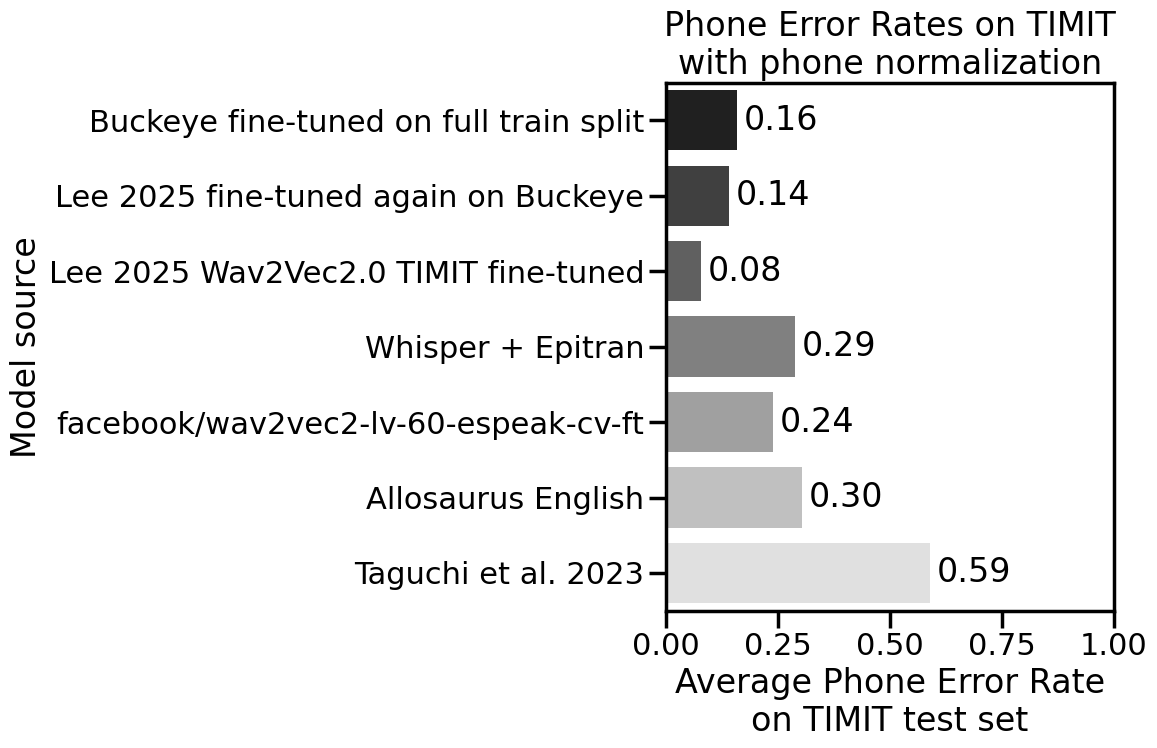

In [47]:
plt.figure(figsize=(12, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_error_rate", hue="Model source", palette=PALETTE, hue_order=hue_order
)
g.set_title("Phone Error Rates on TIMIT\nwith phone normalization")
g.set_xlabel("Average Phone Error Rate\non TIMIT test set")
g.set_xlim((0,1))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_PER_post_proc.eps", format="eps")

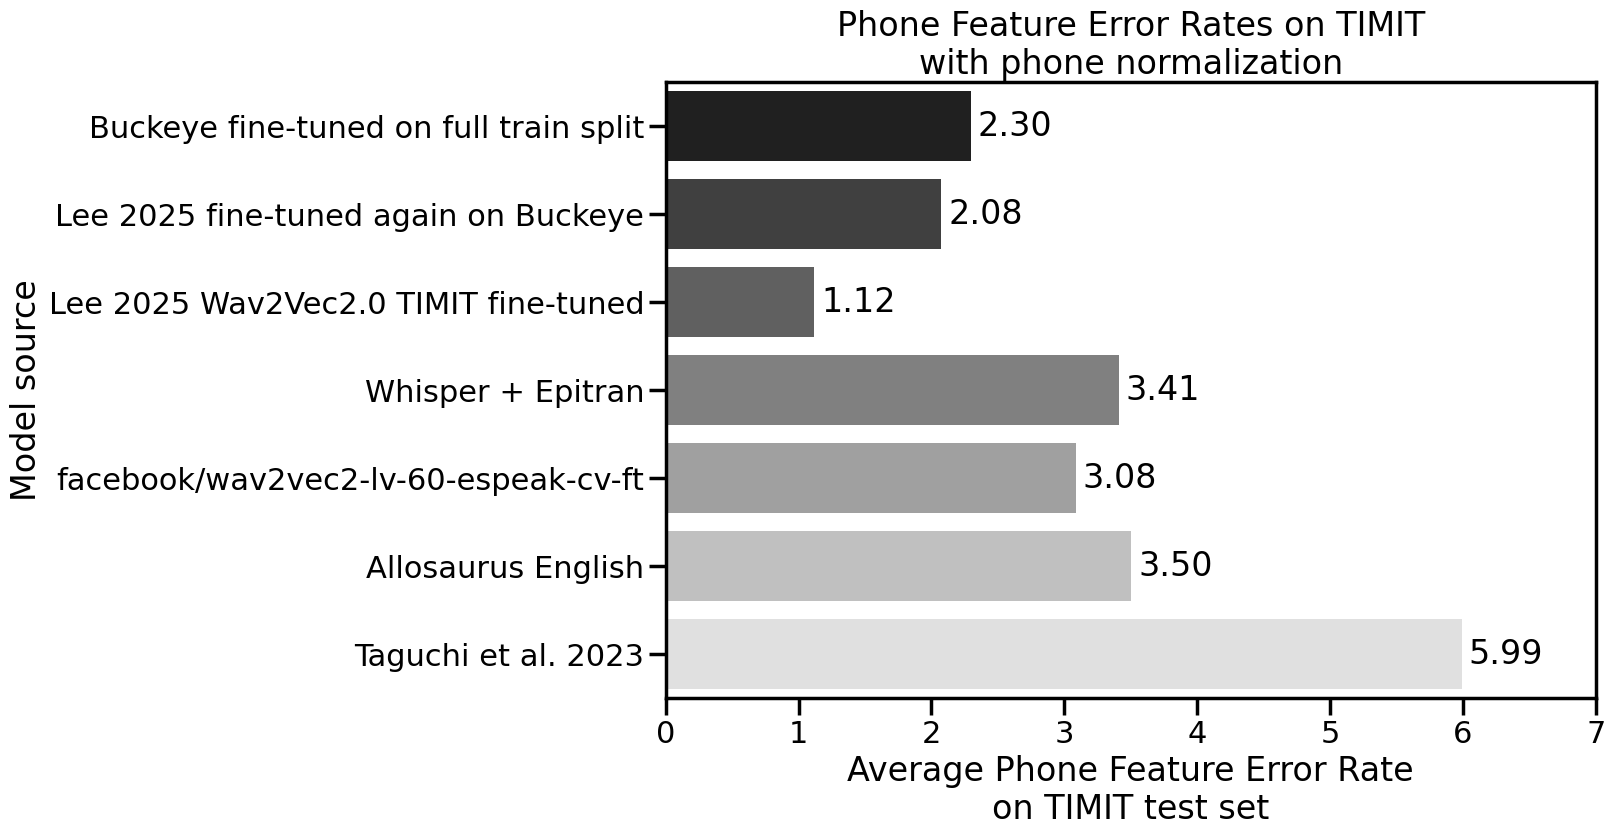

In [48]:
plt.figure(figsize=(12, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_feature_error_rate", hue="Model source", palette=PALETTE, hue_order=hue_order
)
g.set_title("Phone Feature Error Rates on TIMIT\nwith phone normalization")
g.set_xlabel("Average Phone Feature Error Rate\non TIMIT test set")
g.set_xlim((0,7))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)

plt.savefig(VIZ_OUTPUT_DIR / "timit_PFER_post_proc.eps", format="eps")

# Dialect Region Performance Plots
This creates bar charts showing performance by dialect. Since the groupby and averaging was already done, we just need to read in the data and plot the results.

In [17]:
DIALECT_KEY = "dialect"

In [18]:
# Read in predictions and extract dialect region
all_results_df[DIALECT_KEY] = all_results_df["filename"].apply(lambda x: x.split("/")[1].upper())
display(all_results_df.head())


,file,ipa,relative_file_path,filename,prediction,model,model_name,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates,substitutions,deletions,insertions,dialect
0,/Users/virginia/workspace/multipa/data/TIMIT/T...,ʃihædjɹ̩dɑɹksuɾɪŋɡɹisiwɑʃwɑɾɹ̩ʔɔljiɹ̩,/DR1/FAKS0/SA1.WAV,/DR1/FAKS0/SA1.WAV,ʃihædjɹ̩dɑɹksuɾɪnɡɹissiwɑʃwɔɾɹ̩ɔljiɹ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.147059,2.416667,0.125613,"{('ŋ', 'n'): 1, ('ɑ', 'ɔ'): 1, ('ɹ̩', 'ɹ'): 1}",{'ʔ': 1},{'s': 1},DR1
1,/Users/virginia/workspace/multipa/data/TIMIT/T...,doʊnæsmitɪkɛɹiɪnɔɪliɹæɡlaɪkðæt,/DR1/FAKS0/SA2.WAV,/DR1/FAKS0/SA2.WAV,doʊnæskmitɪkæɹiɪnɔɪliɹɛɡlaɪkðæʔ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.133333,1.416667,0.218750,"{('ɛ', 'æ'): 1, ('æ', 'ɛ'): 1, ('t', 'ʔ'): 1}",{},{'k': 1},DR1
2,/Users/virginia/workspace/multipa/data/TIMIT/T...,hɪzkæptɪnwəsθɪnænhæɡɹ̩dɪnɪzbjuɾufl̩butswɹ̩wɔɹn...,/DR1/FAKS0/SI1573.WAV,/DR1/FAKS0/SI1573.WAV,hɪzkæptənwəzsθɪnɛnhæɡɹ̩dɛnɪzbjuɾəfl̩butswɹ̩wɔɹ...,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.142857,2.416667,0.294218,"{('ɪ', 'ə'): 1, ('æ', 'ɛ'): 1, ('ɪ', 'ɛ'): 2, ...",{},"{'z': 1, 't': 1}",DR1
3,/Users/virginia/workspace/multipa/data/TIMIT/T...,ðɪɹizənzfɹ̩ðɪsdaɪvsimdfulɪʃnaʊ,/DR1/FAKS0/SI2203.WAV,/DR1/FAKS0/SI2203.WAV,ðəɹizən̩zfɹ̩ðɪstaɪvsimdfulɪʃnaʊ,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.103448,0.166667,0.278017,"{('ɪ', 'ə'): 1, ('n', 'n̩'): 1, ('d', 't'): 1}",{},{},DR1
4,/Users/virginia/workspace/multipa/data/TIMIT/T...,pɹ̩dəkʃɪnmeɪfɔlfɑɹbəloʊəkspɪkteɪʃn̩ts,/DR1/FAKS0/SI943.WAV,/DR1/FAKS0/SI943.WAV,pɹədəkʃənmeɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃəns,ginic/full_dataset_train_5_wav2vec2-large-xlsr...,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,0.228571,1.958333,0.176786,"{('ɹ̩', 'ɹ'): 1, ('ɪ', 'ə'): 1, ('ə', 'l̩'): 1...",{},{'ə': 1},DR1


In [19]:
# Show performance by dialect region
dialect_df = all_results_df.groupby([MODEL_NAME_KEY, MODEL_SOURCE_KEY, DIALECT_KEY])["phone_error_rates"].mean().reset_index()
display(dialect_df.head())
dialect_df = dialect_df.merge(pd.DataFrame(DIALECT_REGIONS.items(), columns=[DIALECT_KEY, "Dialect Region"]), on=DIALECT_KEY)
dialect_df =  dialect_df.sort_values(by=["Dialect Region", "phone_error_rates"], ascending=[True, True])
display(dialect_df)

,model_name,Model source,dialect,phone_error_rates
0,allosaurus_eng2102_eng,Allosaurus English,DR1,0.321775
1,allosaurus_eng2102_eng,Allosaurus English,DR2,0.287486
2,allosaurus_eng2102_eng,Allosaurus English,DR3,0.282742
3,allosaurus_eng2102_eng,Allosaurus English,DR4,0.312445
4,allosaurus_eng2102_eng,Allosaurus English,DR5,0.323464


,model_name,Model source,dialect,phone_error_rates,Dialect Region
2,excalibur12_wav2vec2-large-lv60_phoneme-timit_...,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,DR1,0.090047,DR1: New England
5,ginic_wav2vec2-large-lv60_phoneme-timit_englis...,Lee 2025 fine-tuned again on Buckeye,DR1,0.148590,DR1: New England
4,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,DR1,0.163672,DR1: New England
3,facebook_wav2vec2-lv-60-espeak-cv-ft,facebook/wav2vec2-lv-60-espeak-cv-ft,DR1,0.243949,DR1: New England
6,openai_whisper-medium.en_to_epitran,Whisper + Epitran,DR1,0.307702,DR1: New England
0,allosaurus_eng2102_eng,Allosaurus English,DR1,0.321775,DR1: New England
1,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,Taguchi et al. 2023,DR1,0.586434,DR1: New England
9,excalibur12_wav2vec2-large-lv60_phoneme-timit_...,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,DR2,0.074081,DR2: Northern
12,ginic_wav2vec2-large-lv60_phoneme-timit_englis...,Lee 2025 fine-tuned again on Buckeye,DR2,0.131203,DR2: Northern
11,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,Buckeye fine-tuned on full train split,DR2,0.144674,DR2: Northern


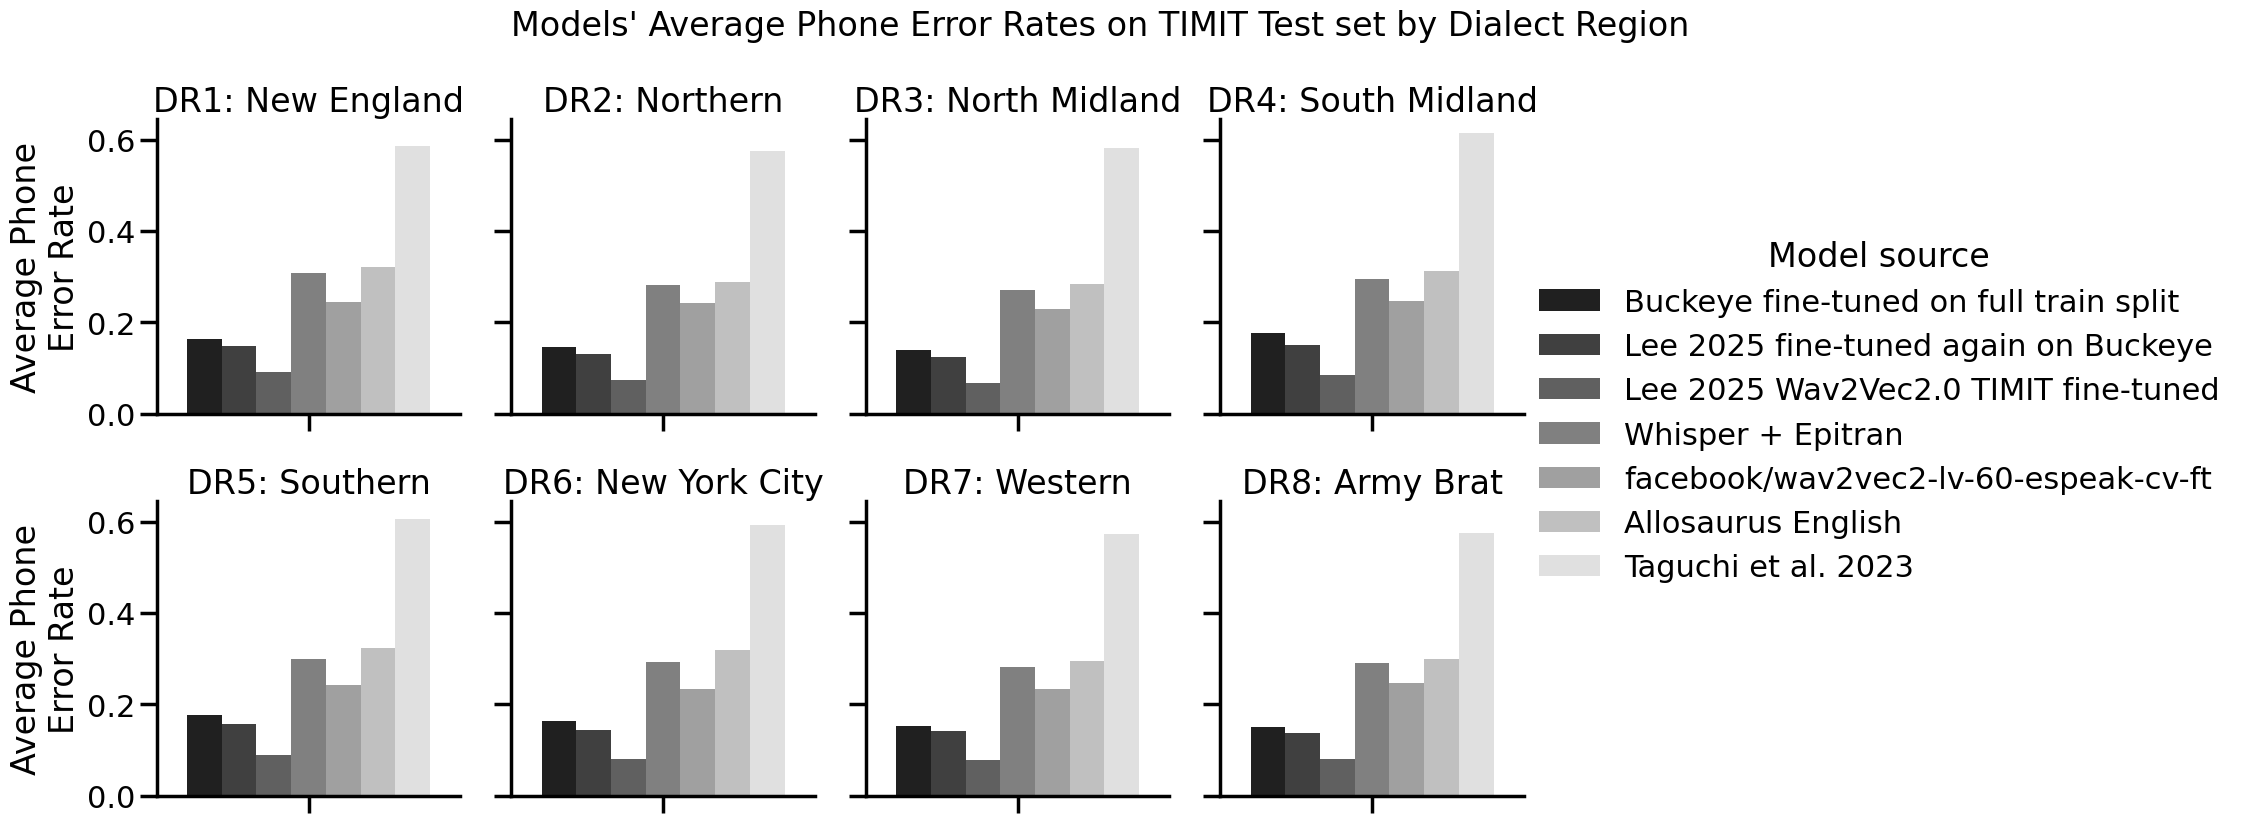

In [37]:
g = sns.FacetGrid(dialect_df, col="Dialect Region", col_wrap=4, height=4)
g.set_titles(col_template="{col_name}")
g.map_dataframe(sns.barplot, y="phone_error_rates", hue=MODEL_SOURCE_KEY, palette=PALETTE, hue_order = hue_order)
g.add_legend(title=MODEL_SOURCE_KEY)
g.set_ylabels("Average Phone\nError Rate")
g.figure.suptitle("Models' Average Phone Error Rates on TIMIT Test set by Dialect Region", fontsize=24, y=1.05)
plt.savefig(VIZ_OUTPUT_DIR / "timit_dialect_results.eps", format="eps")


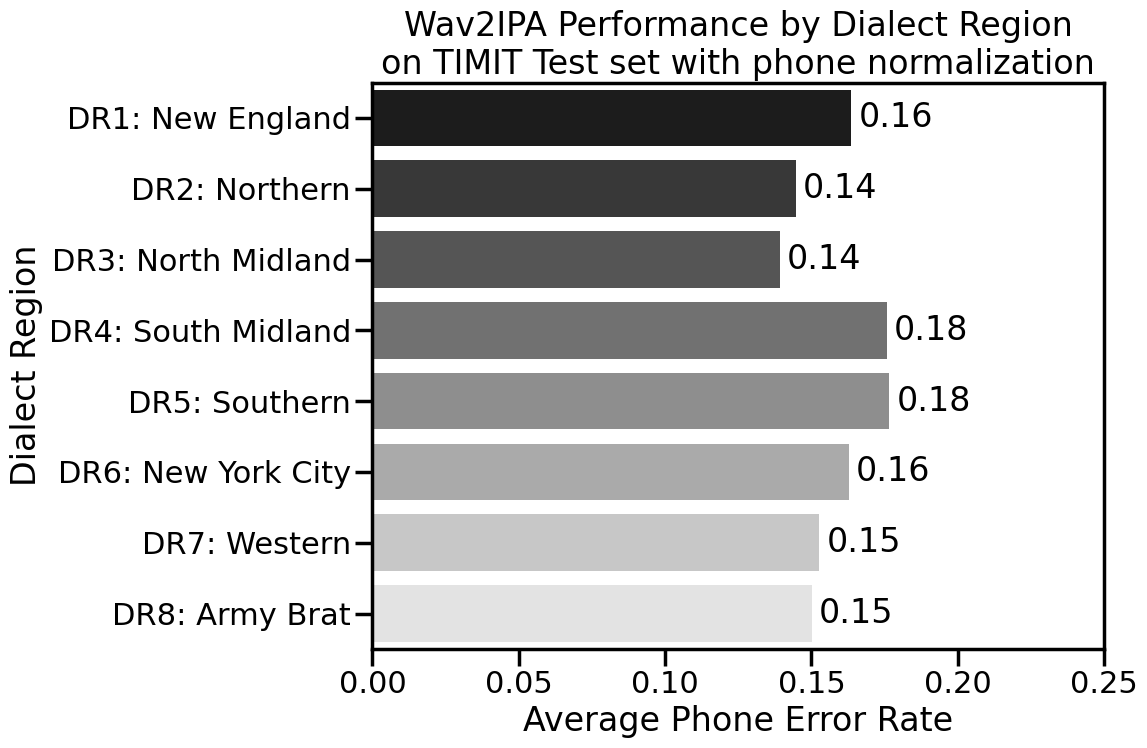

In [52]:
# Dialect performance for just our model
our_model_dialect_df = dialect_df[dialect_df[MODEL_SOURCE_KEY] == "Buckeye fine-tuned on full train split"]
plt.figure(figsize=(12, 8))
g = sns.barplot(data=our_model_dialect_df, y="Dialect Region", x="phone_error_rates", hue="Dialect Region", palette=PALETTE)
g.set_xlabel("Average Phone Error Rate")
g.set_xlim((0,0.25))
g.set(title="Wav2IPA Performance by Dialect Region\non TIMIT Test set with phone normalization")
for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)

plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_wav2ipa_detailed_dialect.eps", format="eps")

# Vowel Error Rate Analysis
How many instances of each vowel in the vocabulary are we getting wrong? 
$$ error\_rate(v) = \frac{count\_substitutions\_of(v) + count\_deletions(v)}{total\_count(v)}$$

In [22]:
# Determine token sent and vowel and consonant counts
timit_phones = set(phonecode_tables._timit2ipa.values()) - set(phonecode_tables.TIMIT_IPA_TO_TIMIT_BUCKEYE_SHARED.keys())
potential_consonants = (timit_phones - set(TIMIT_VOWELS)) - set(TIMIT_DIPHTHONGS)
print(potential_consonants)

true_token_counts = EVALUATOR._true_token_counts[OUR_BEST_MODEL]
vowel_counts = Counter()
for vowel in TIMIT_VOWELS + TIMIT_DIPHTHONGS:
    c = true_token_counts[vowel]
    if c > 0:
        vowel_counts[vowel] = c
print("Vowel counts:", vowel_counts)

cons_counts = Counter()
for cons in potential_consonants:
    c = true_token_counts[cons]
    if c > 0:
        cons_counts[cons] = c

TIMIT_CONSONANTS = list(cons_counts.keys())
print("Consonant counts:", cons_counts)



{'', 'θ', 'ʃ', 'm̩', 't', 'ŋ̩', 'ʔ', 'dʒ', 'l̩', 'ˈ', 'ˌ', 'n̩', 'f', 'ð', 'ɡ', 'n', 'p', 'k', 'b', 'm', 'tʃ', 'ŋ', 'h', 'ɹ', 'ɾ', 'v', 'l', 'ʒ', 'd', 'j', 's', 'z', 'w'}
Vowel counts: Counter({'ɪ': 4652, 'i': 2710, 'ə': 2343, 'ɹ̩': 2183, 'ɛ': 1440, 'æ': 1407, 'ɔ': 1154, 'ɑ': 1133, 'aɪ': 852, 'eɪ': 806, 'oʊ': 777, 'u': 750, 'ɔɪ': 265, 'ʊ': 221, 'aʊ': 216})
Consonant counts: Counter({'n': 2861, 's': 2639, 't': 2578, 'ɹ': 2525, 'l': 2356, 'k': 2070, 'd': 2032, 'm': 1526, 'z': 1273, 'ʔ': 1244, 'w': 1239, 'p': 1086, 'ʃ': 1055, 'ð': 999, 'b': 977, 'ɾ': 940, 'f': 912, 'ɡ': 893, 'h': 725, 'v': 710, 'j': 634, 'ʒ': 446, 'ŋ': 414, 'l̩': 343, 'θ': 263, 'n̩': 251, 'm̩': 47, 'ŋ̩': 5})


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_33151/4102188309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")


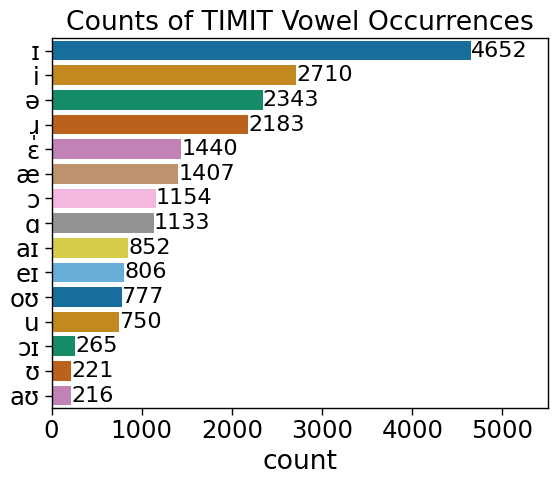

In [23]:
# Simple bar chart of vowel counts
plot_vowels, plot_counts = zip(*vowel_counts.most_common())
g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")
g.set_xlim(0, 5500)
g.set_xlabel("count")
g.set(title="Counts of TIMIT Vowel Occurrences")
for bar in g.containers:
    g.bar_label(bar, fontsize='small')

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_33151/1402713627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")


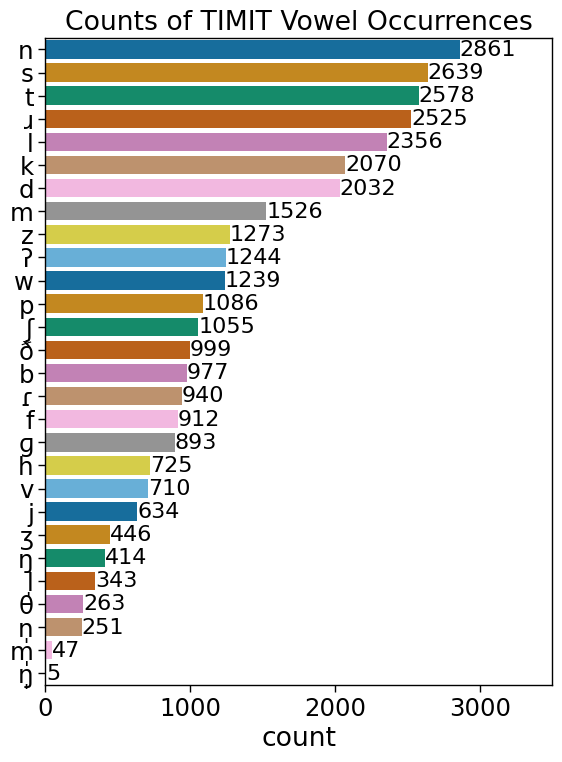

In [24]:
# Simple bar chart of vowel counts
plot_vowels, plot_counts = zip(*cons_counts.most_common())
plt.figure(figsize=(6, 8))
g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")

g.set_xlim(0, 3500)
g.set_xlabel("count")
g.set(title="Counts of TIMIT Vowel Occurrences")
for bar in g.containers:
    g.bar_label(bar, fontsize='small')
plt.tight_layout()

In [25]:
sns.set_context(context="poster", font_scale=1)

In [26]:
# Munge token counts and by phone error rates into dataframes
all_token_counts = Counter()
all_token_counts.update(vowel_counts)
all_token_counts.update(cons_counts)

token_counts_df = pd.DataFrame.from_records(
        list(all_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)


records = []
for model_name, eval_results in EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[EVALUATOR.by_token_error_rates].items():
        if phone in TIMIT_CONSONANTS + TIMIT_VOWELS + TIMIT_DIPHTHONGS:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=[MODEL_NAME_KEY, "phone", "err_rate"])
all_error_rates_df[MODEL_SOURCE_KEY] = all_error_rates_df[MODEL_NAME_KEY].apply(MODEL_LABEL_LOOKUP.get)

all_error_rates_df = multipa.evaluation.compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")

display(all_error_rates_df.head())

,model_name,phone,err_rate,Model source,counts,confidence_interval
0,ginic_full_dataset_train_5_wav2vec2-large-xlsr...,ʃ,0.010427,Buckeye fine-tuned on full train split,1055,0.006129
1,ginic_wav2vec2-large-lv60_phoneme-timit_englis...,ʃ,0.008531,Lee 2025 fine-tuned again on Buckeye,1055,0.005550
2,excalibur12_wav2vec2-large-lv60_phoneme-timit_...,ʃ,0.015166,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,1055,0.007375
3,openai_whisper-medium.en_to_epitran,ʃ,0.281517,Whisper + Epitran,1055,0.027139
4,facebook_wav2vec2-lv-60-espeak-cv-ft,ʃ,0.023697,facebook/wav2vec2-lv-60-espeak-cv-ft,1055,0.009178


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


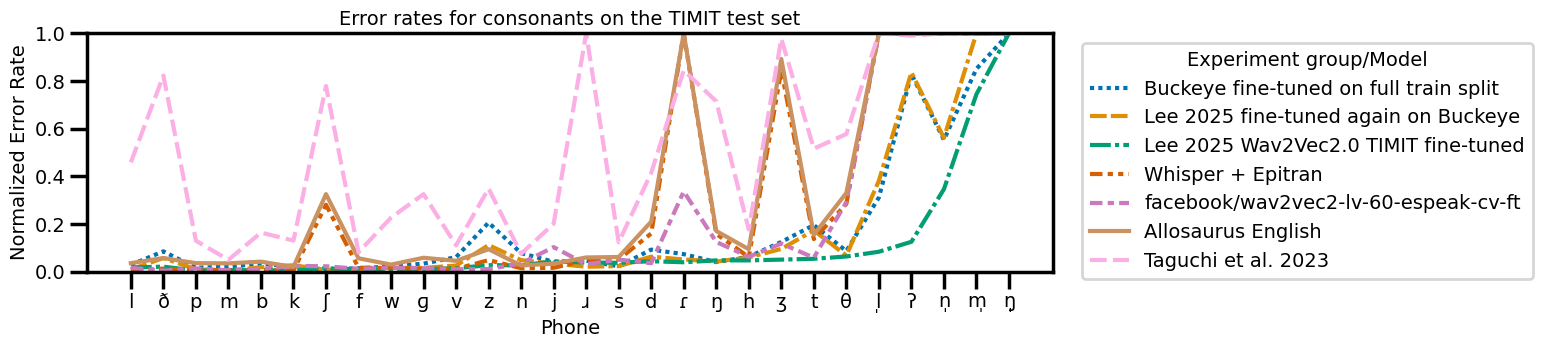

In [27]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(TIMIT_CONSONANTS)]
multipa.visualization.plot_error_rates_by_phone_and_model(consonant_df, MODEL_SOURCE_KEY, hue_order=hue_order, palette="colorblind", title="Error rates for consonants on the TIMIT test set", figsize=(16, 4))
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_consonants_error_rates.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


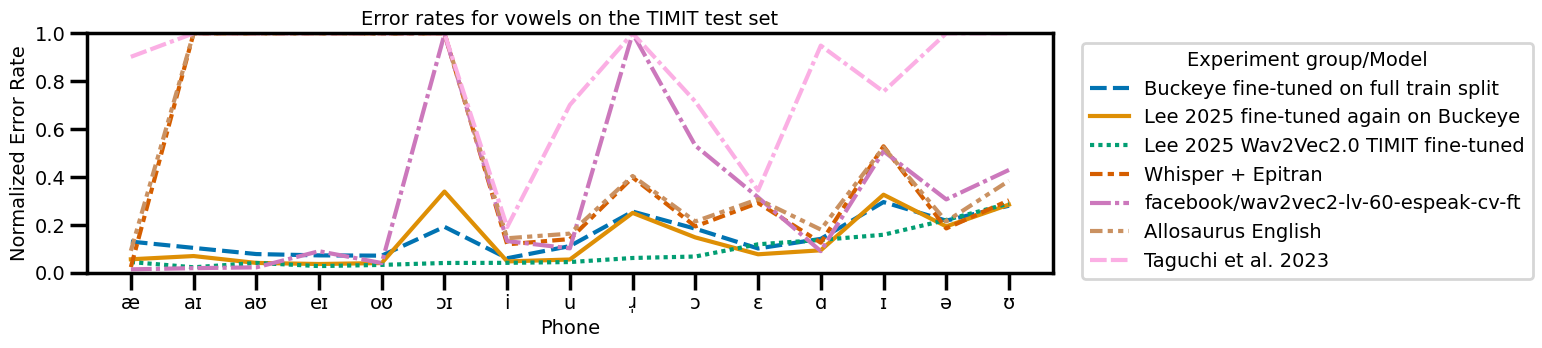

In [28]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(TIMIT_DIPHTHONGS + TIMIT_VOWELS)]
multipa.visualization.plot_error_rates_by_phone_and_model(vowel_df, MODEL_SOURCE_KEY, hue_order=hue_order, palette="colorblind", title="Error rates for vowels on the TIMIT test set", figsize=(16, 4))
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_vowel_error_rates.eps", format="eps")

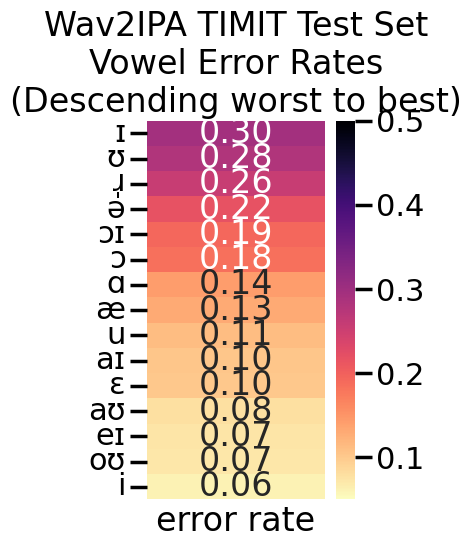

In [29]:
tmp_df = vowel_df[vowel_df[MODEL_NAME_KEY] == OUR_BEST_MODEL][["phone", "err_rate"]]
tmp_df = tmp_df.sort_values(by="err_rate", ascending=False).set_index("phone")
plt.figure(figsize=(4, 6))
sns.heatmap(
    tmp_df,
    cmap="magma_r",
    # cmap="spring_r",
    annot=True,
    fmt=".2f",
    yticklabels=True,
    xticklabels=False,
    # linewidths=1,
    vmin=0.05,
    vmax=0.5
)
plt.title("Wav2IPA TIMIT Test Set\nVowel Error Rates\n(Descending worst to best)")
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("error rate")
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_ver_heatmap.eps", format="eps")
plt.show()


In [30]:
interesting_vowels = vowel_df[(vowel_df["err_rate"] > 0.0) & (vowel_df[MODEL_NAME_KEY] == OUR_BEST_MODEL) ]["phone"].tolist()

# Sanity check there's no duplicates
assert len(interesting_vowels) == len(set(interesting_vowels))

model_results_to_include = EVALUATOR.results_to_write[OUR_BEST_MODEL]

interesting_errors = []
for v in interesting_vowels:
    for ((x, y), c) in model_results_to_include["substitutions"].items():
        if x == v:
            interesting_errors.append((v, y, c))

    dels = model_results_to_include["deletions"][v]
    interesting_errors.append((v, "***", dels))


interesting_errors_df = pd.DataFrame(interesting_errors, columns=["Vowel", "Error", "Count"])
interesting_errors_df["Ratio of Vowel's Errors"] = interesting_errors_df.groupby("Vowel", group_keys=False)["Count"].apply(lambda x: x / x.sum())
display(interesting_errors_df.head())


,Vowel,Error,Count,Ratio of Vowel's Errors
0,i,ɪ,111,0.668675
1,i,ɛ,4,0.024096
2,i,u,2,0.012048
3,i,eɪ,23,0.138554
4,i,j,4,0.024096


In [31]:
# Grab top 5 errors for each vowel
top_errors_df = interesting_errors_df.groupby("Vowel").apply(lambda x: x.nlargest(5, "Count")).reset_index(drop=True)
top_errors_df["Vowel"] = pd.Categorical(top_errors_df["Vowel"], ordered=True)
top_errors_df = top_errors_df.sort_values(by=["Vowel", "Count"], ascending=[True, False])
display(top_errors_df.head(10))

,Vowel,Error,Count,Ratio of Vowel's Errors
0,aɪ,ɑ,61,0.685393
1,aɪ,æ,11,0.123596
2,aɪ,aʊ,6,0.067416
3,aɪ,ə,4,0.044944
4,aɪ,ɪ,2,0.022472
5,aʊ,ɑ,6,0.352941
6,aʊ,æ,4,0.235294
7,aʊ,oʊ,2,0.117647
8,aʊ,l,1,0.058824
9,aʊ,ɔ,1,0.058824


<Figure size 1600x1600 with 0 Axes>

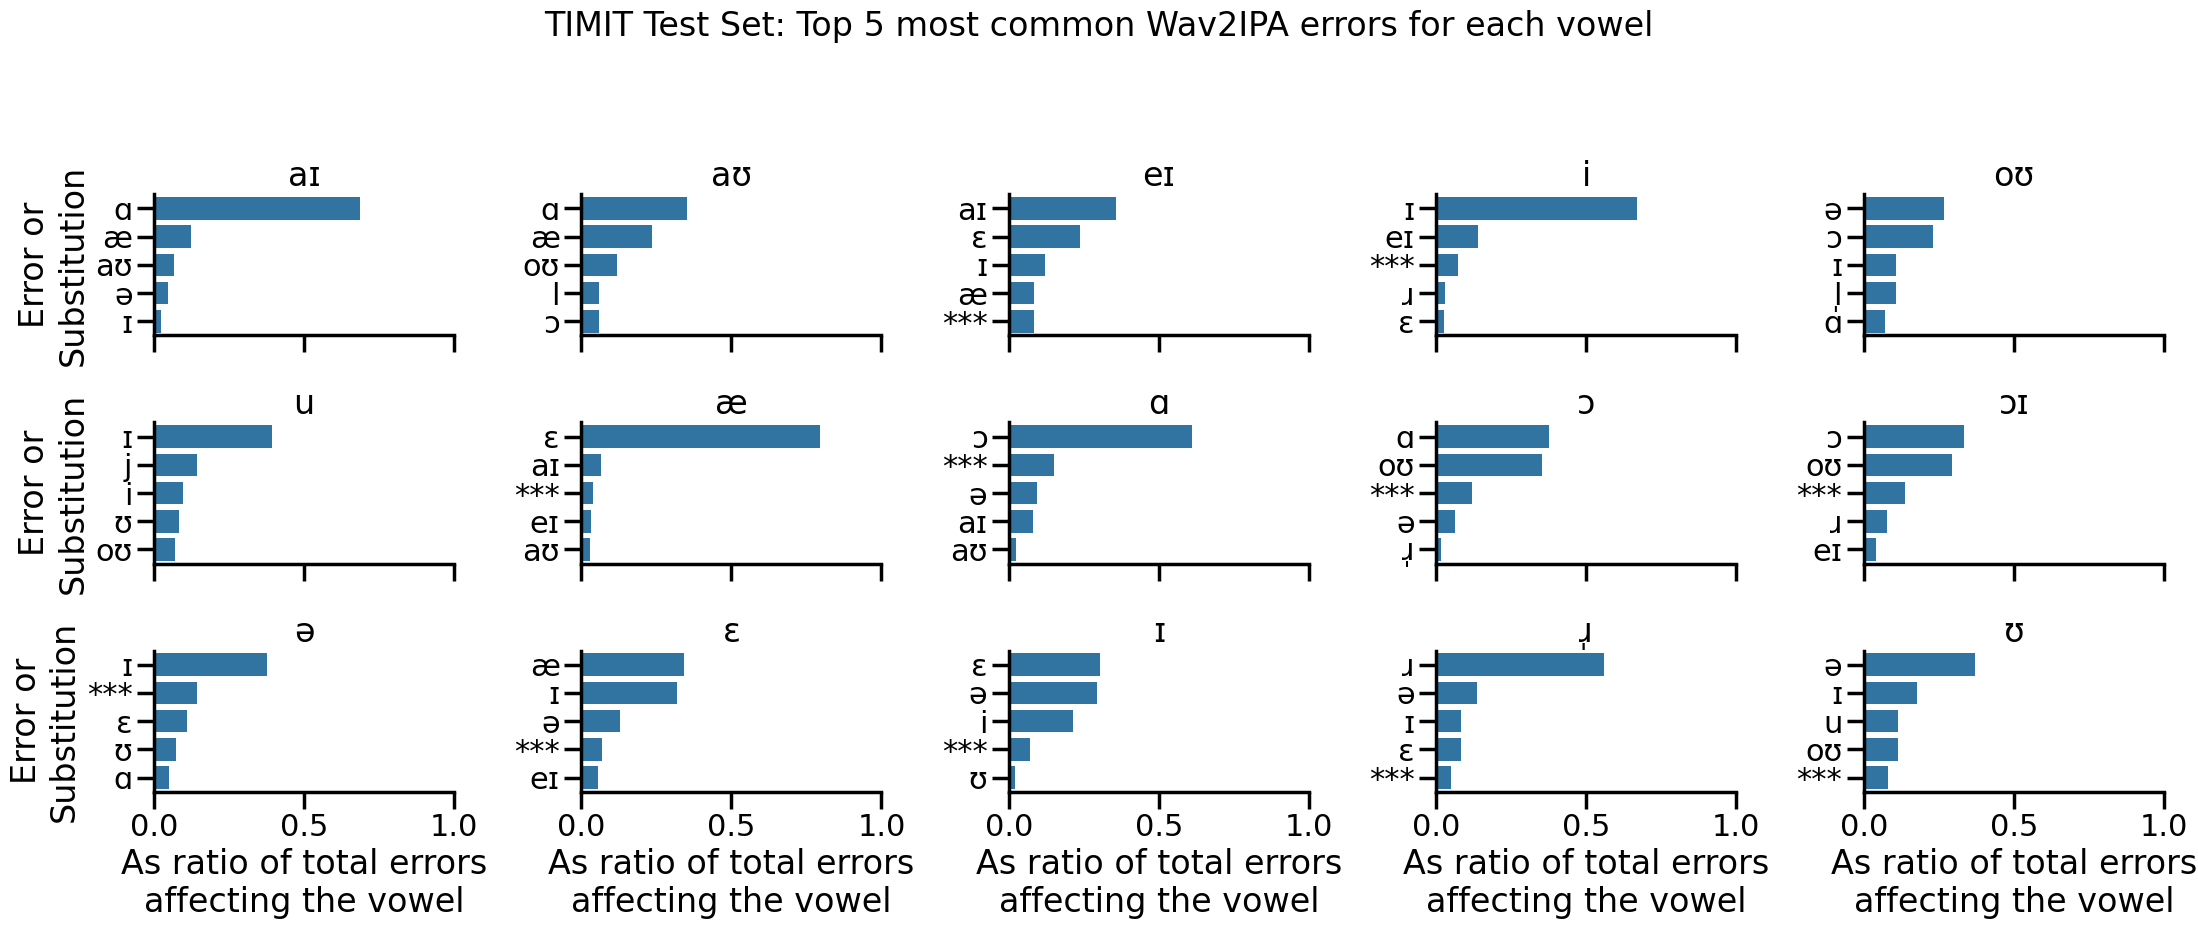

In [32]:
# All vowels together
plt.figure(figsize=(16, 16))
g = sns.FacetGrid(top_errors_df, col="Vowel", col_wrap=5, sharey=False, aspect=1.5, xlim=(0, 1))
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}", fontsize=20)
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("TIMIT Test Set: Top 5 most common Wav2IPA errors for each vowel", fontsize=24, y=1.05)
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "timit_ver_heatmap.eps", format="eps")

# Confusion Matrices
Get the confusion matrix for each model's errors. Display confusion matrices for consonants and vowels separately. 

Model name: ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
Model name: ginic_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k
Model name: openai_whisper-medium.en_to_epitran
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: allosaurus_eng2102_eng
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns


<Figure size 640x480 with 0 Axes>

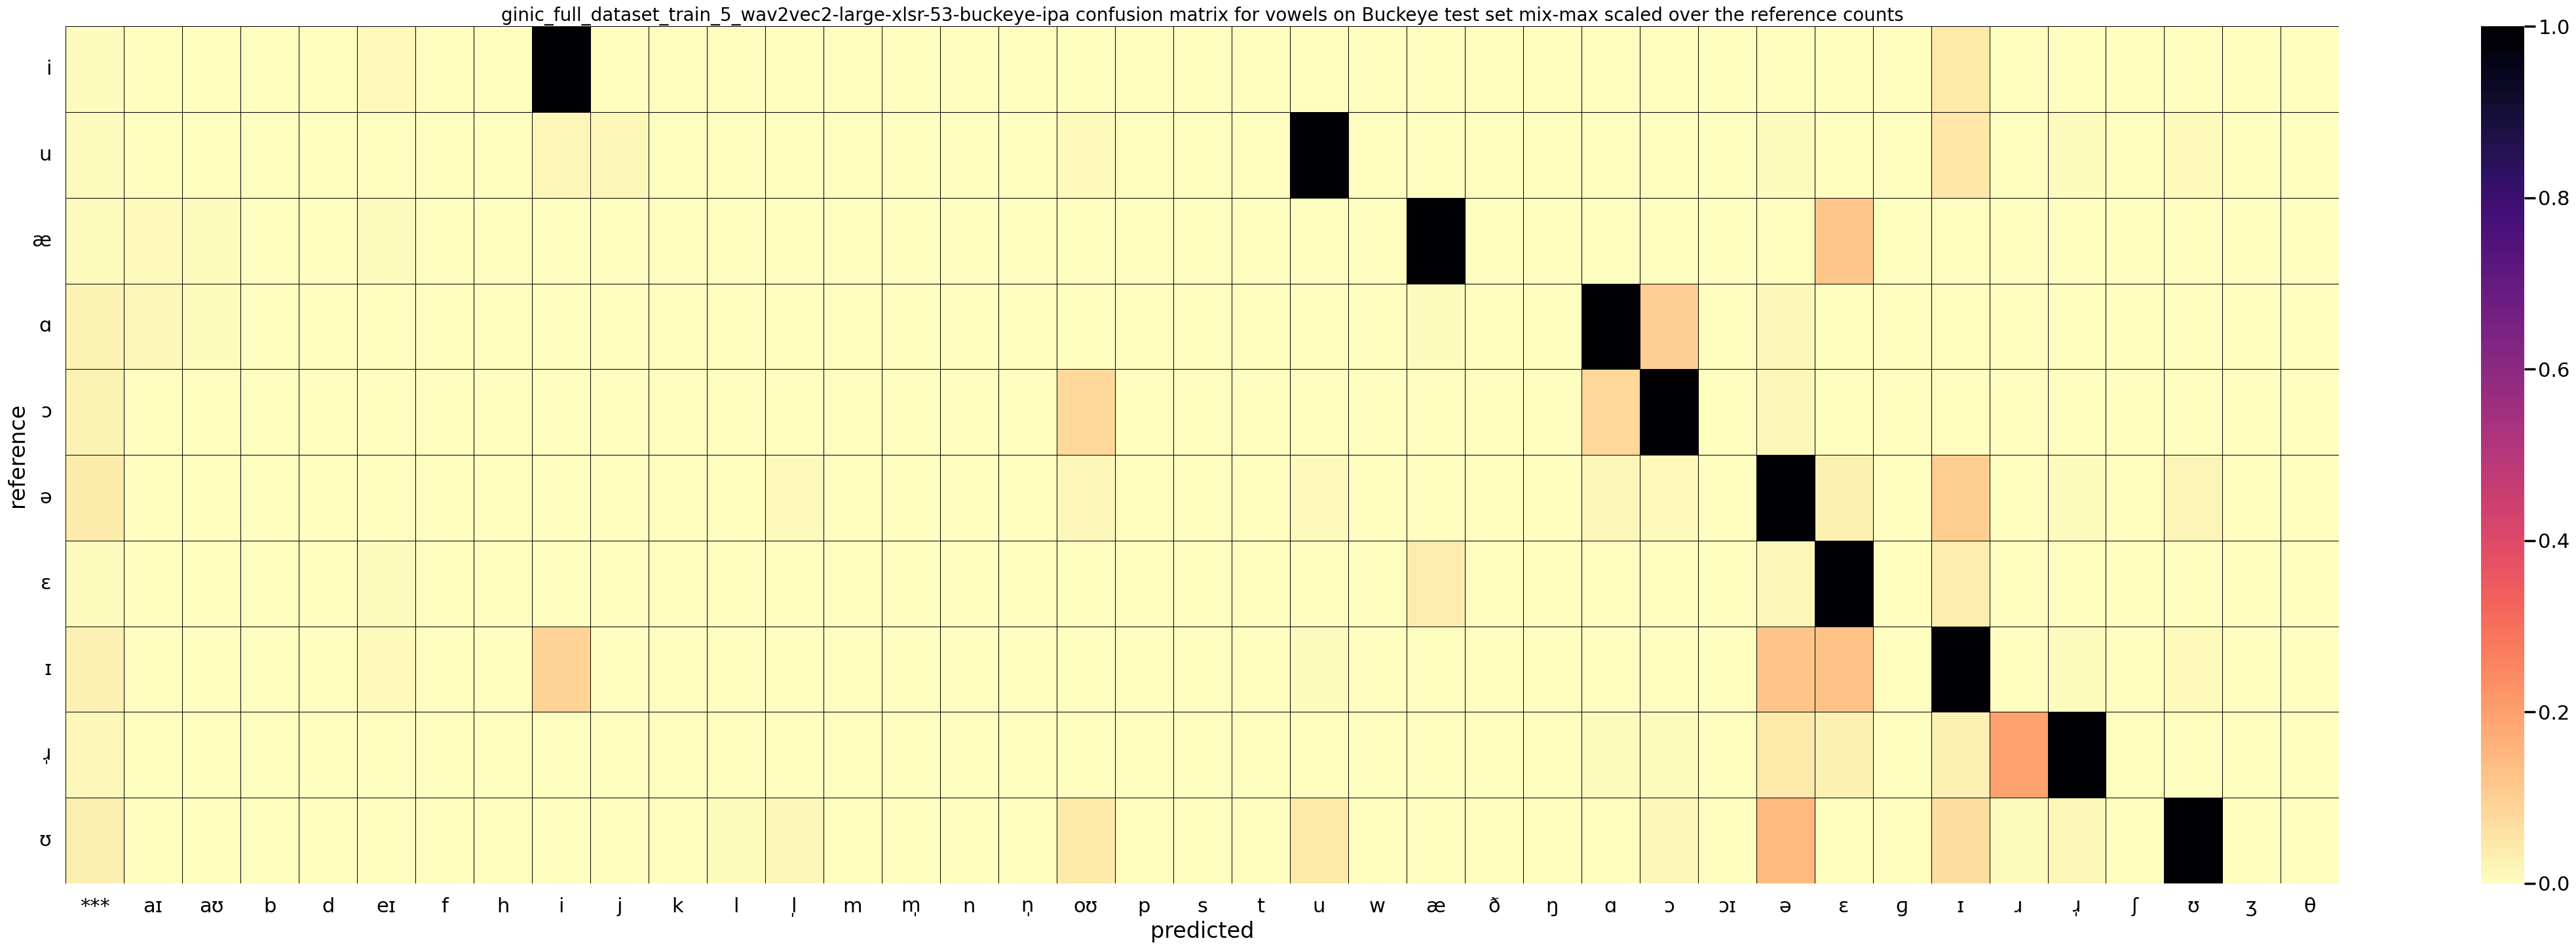

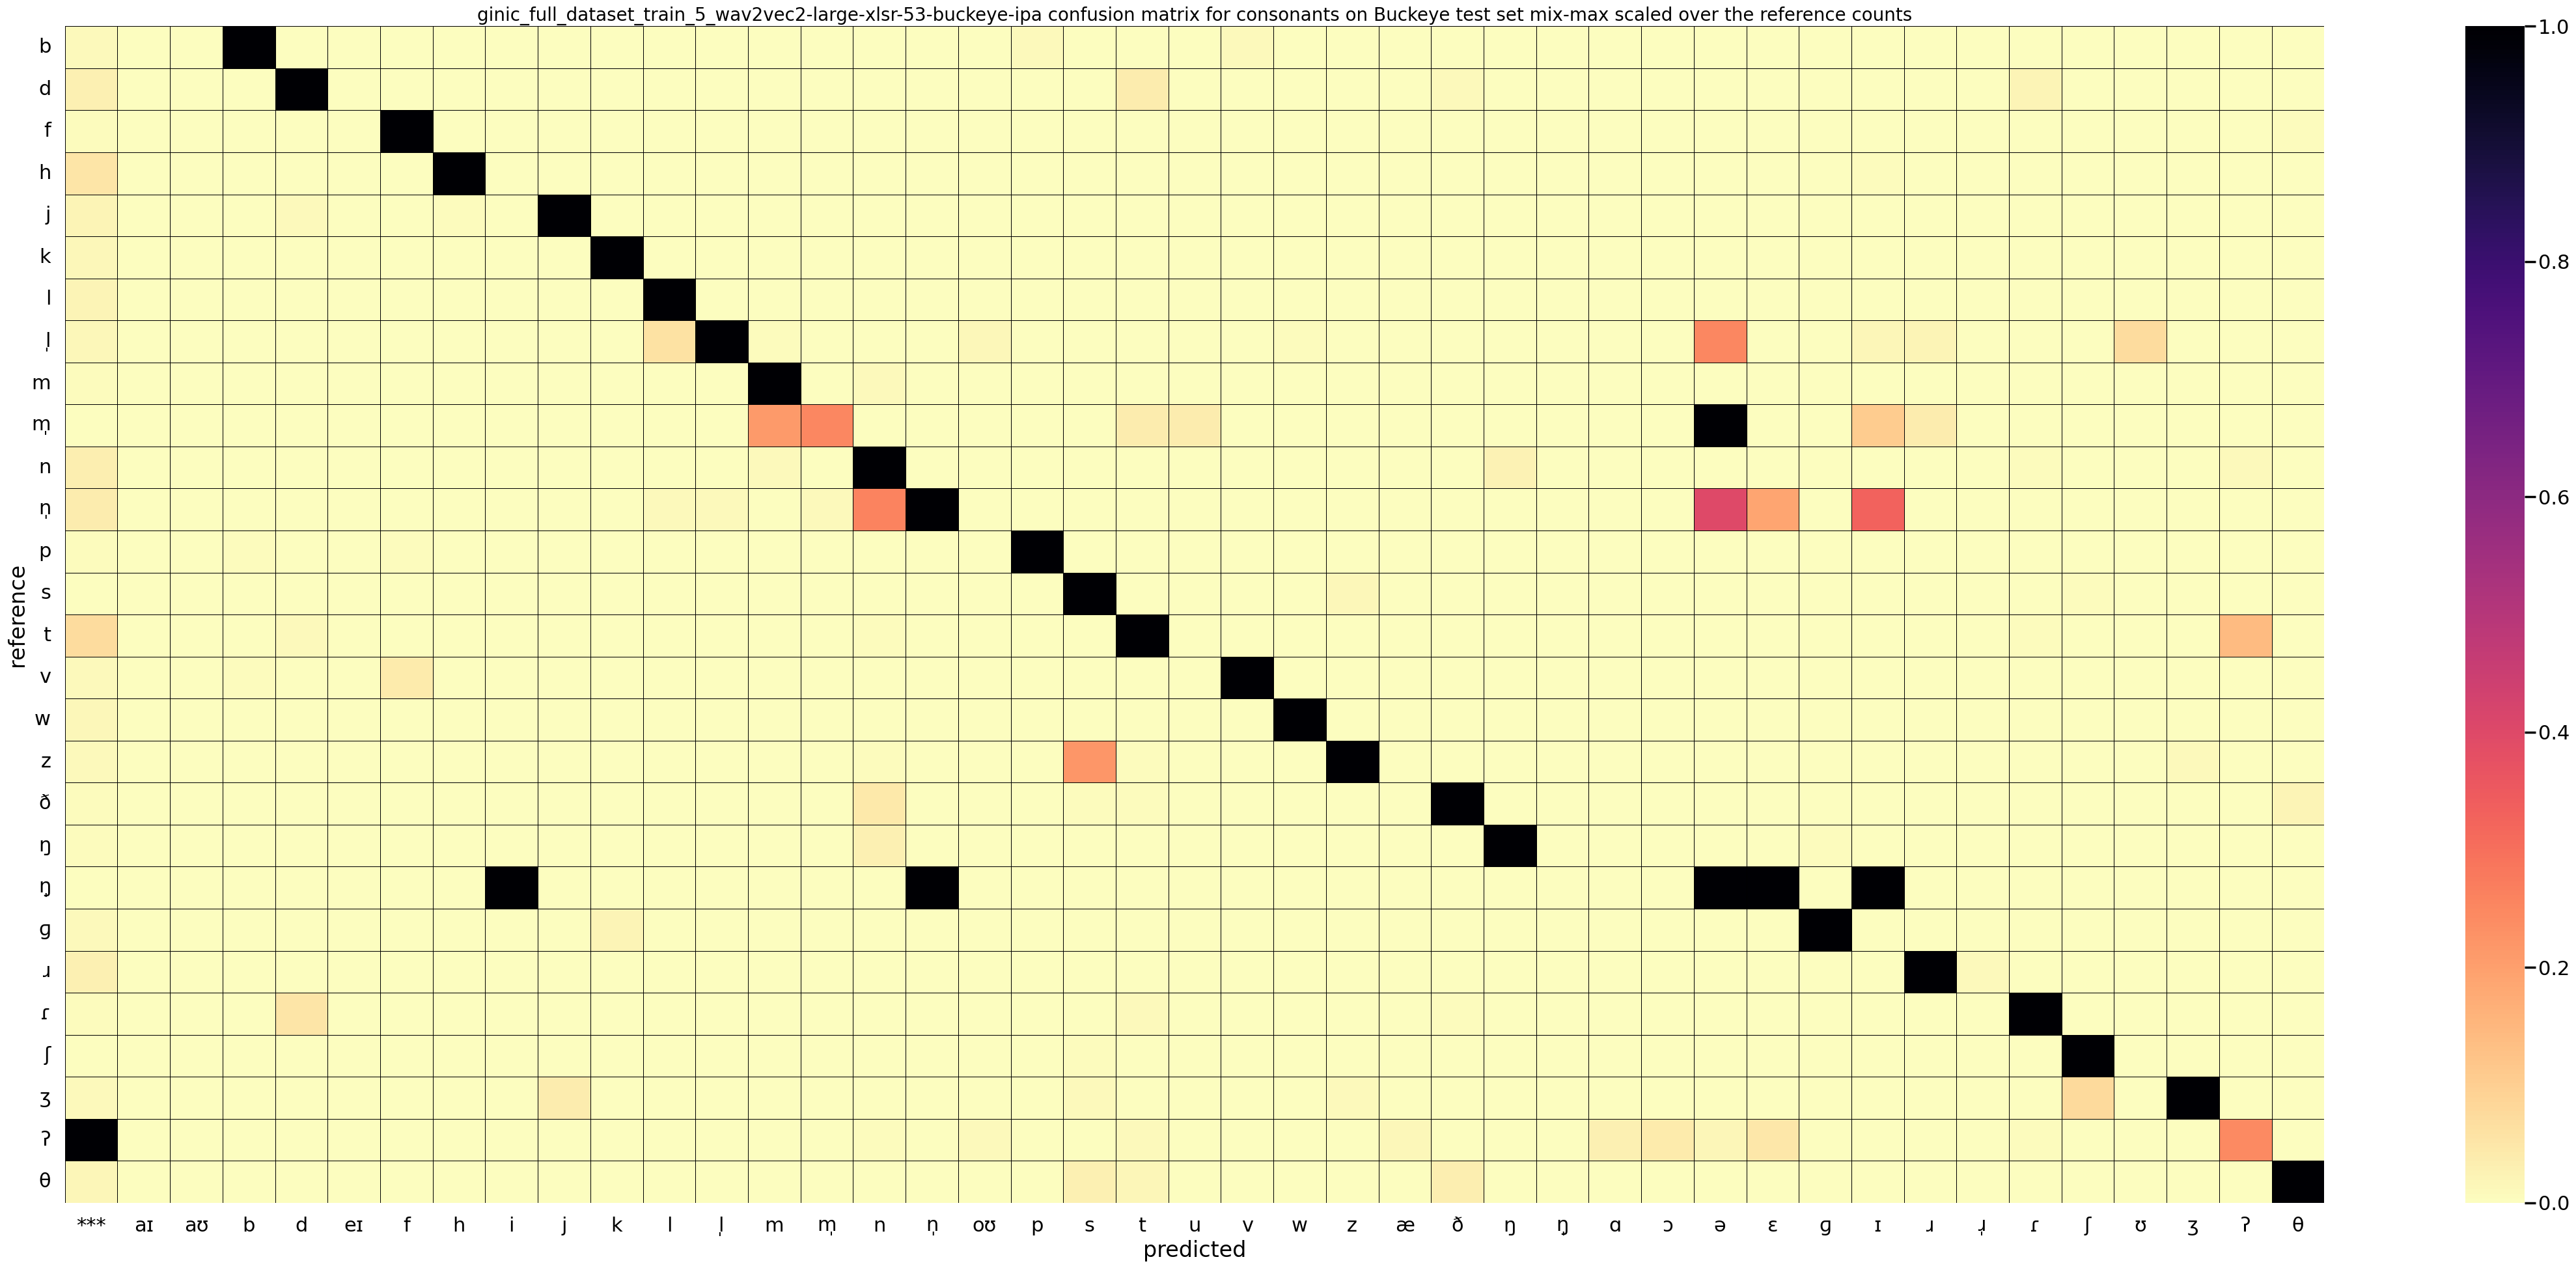

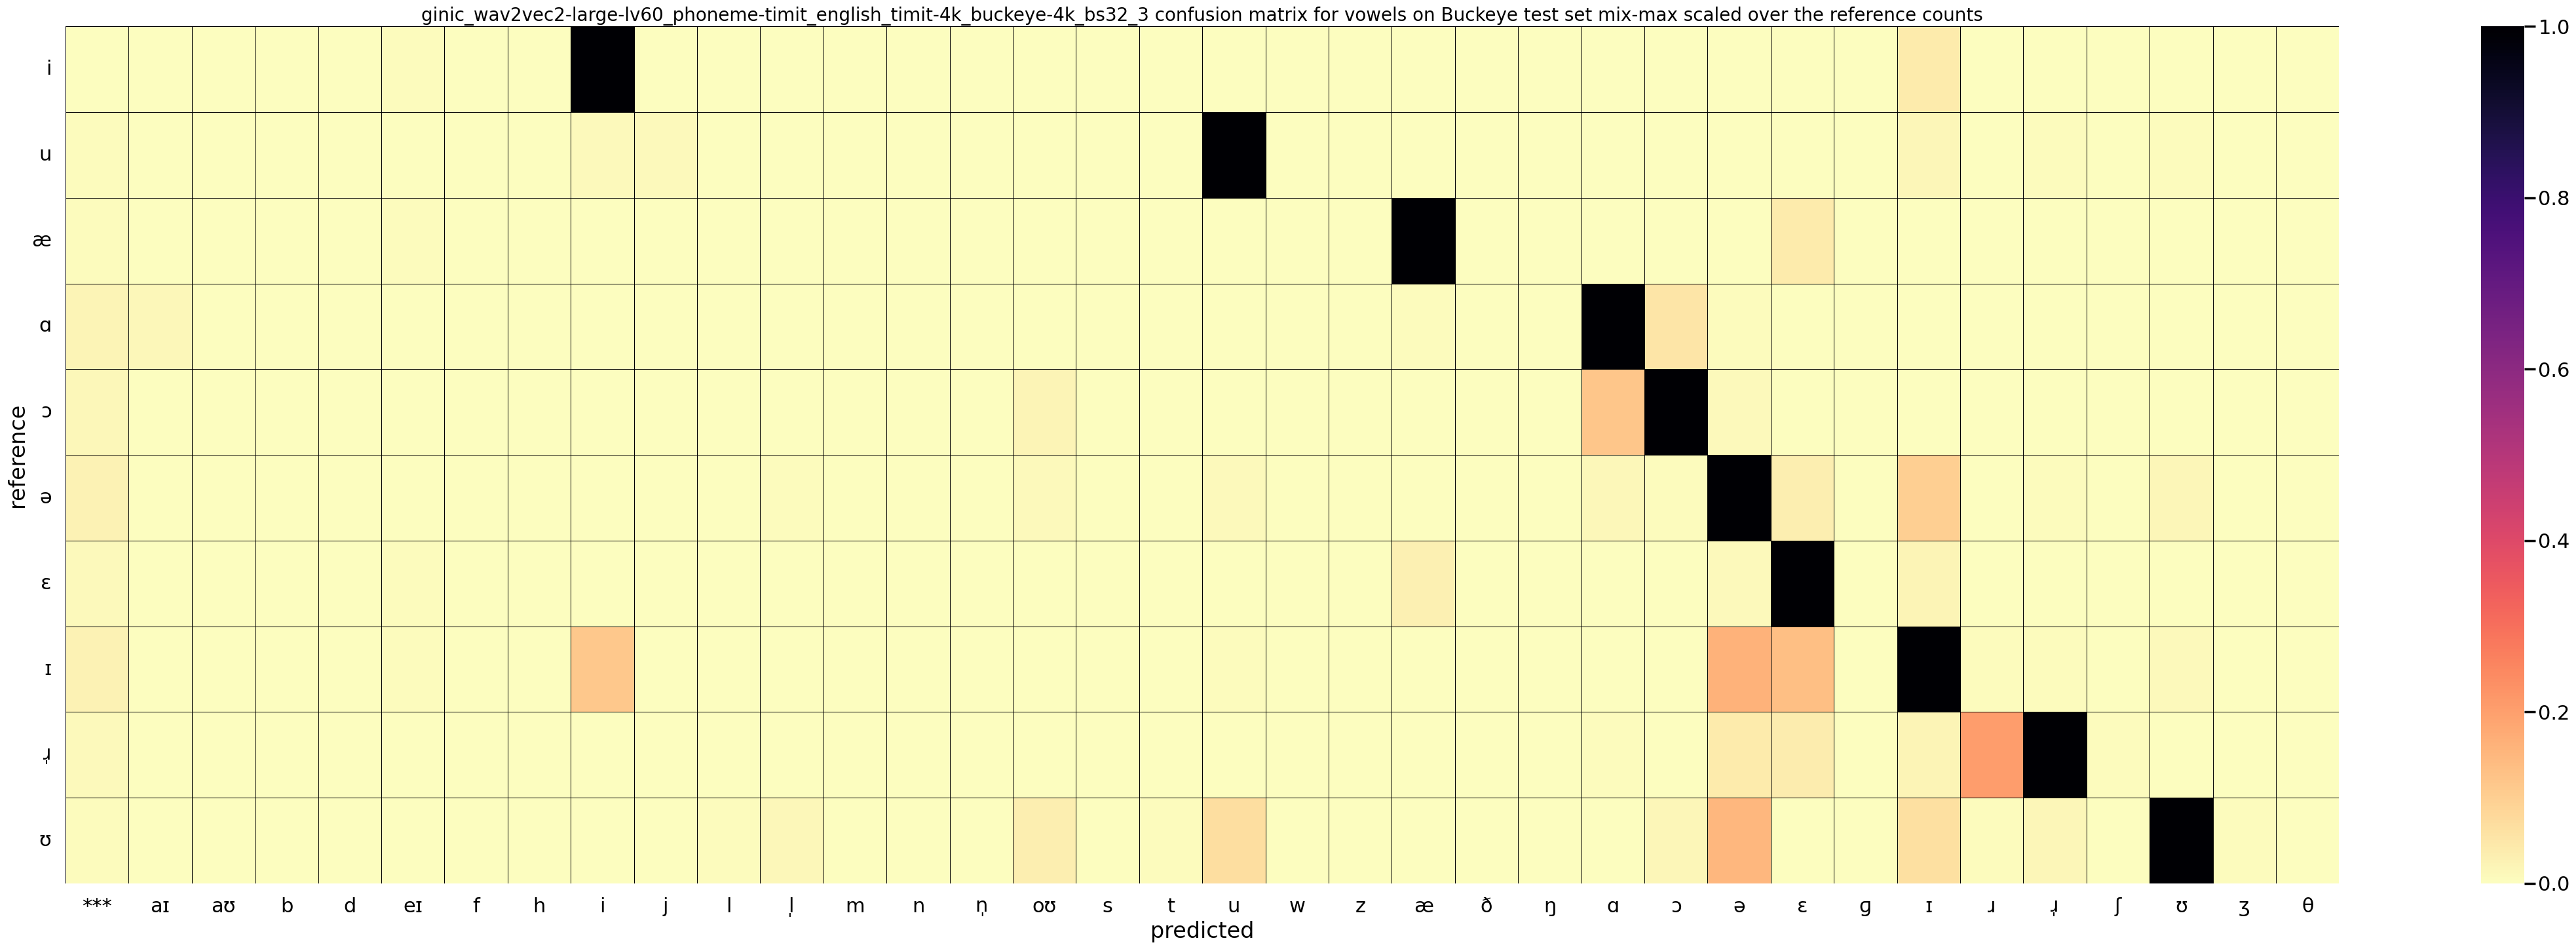

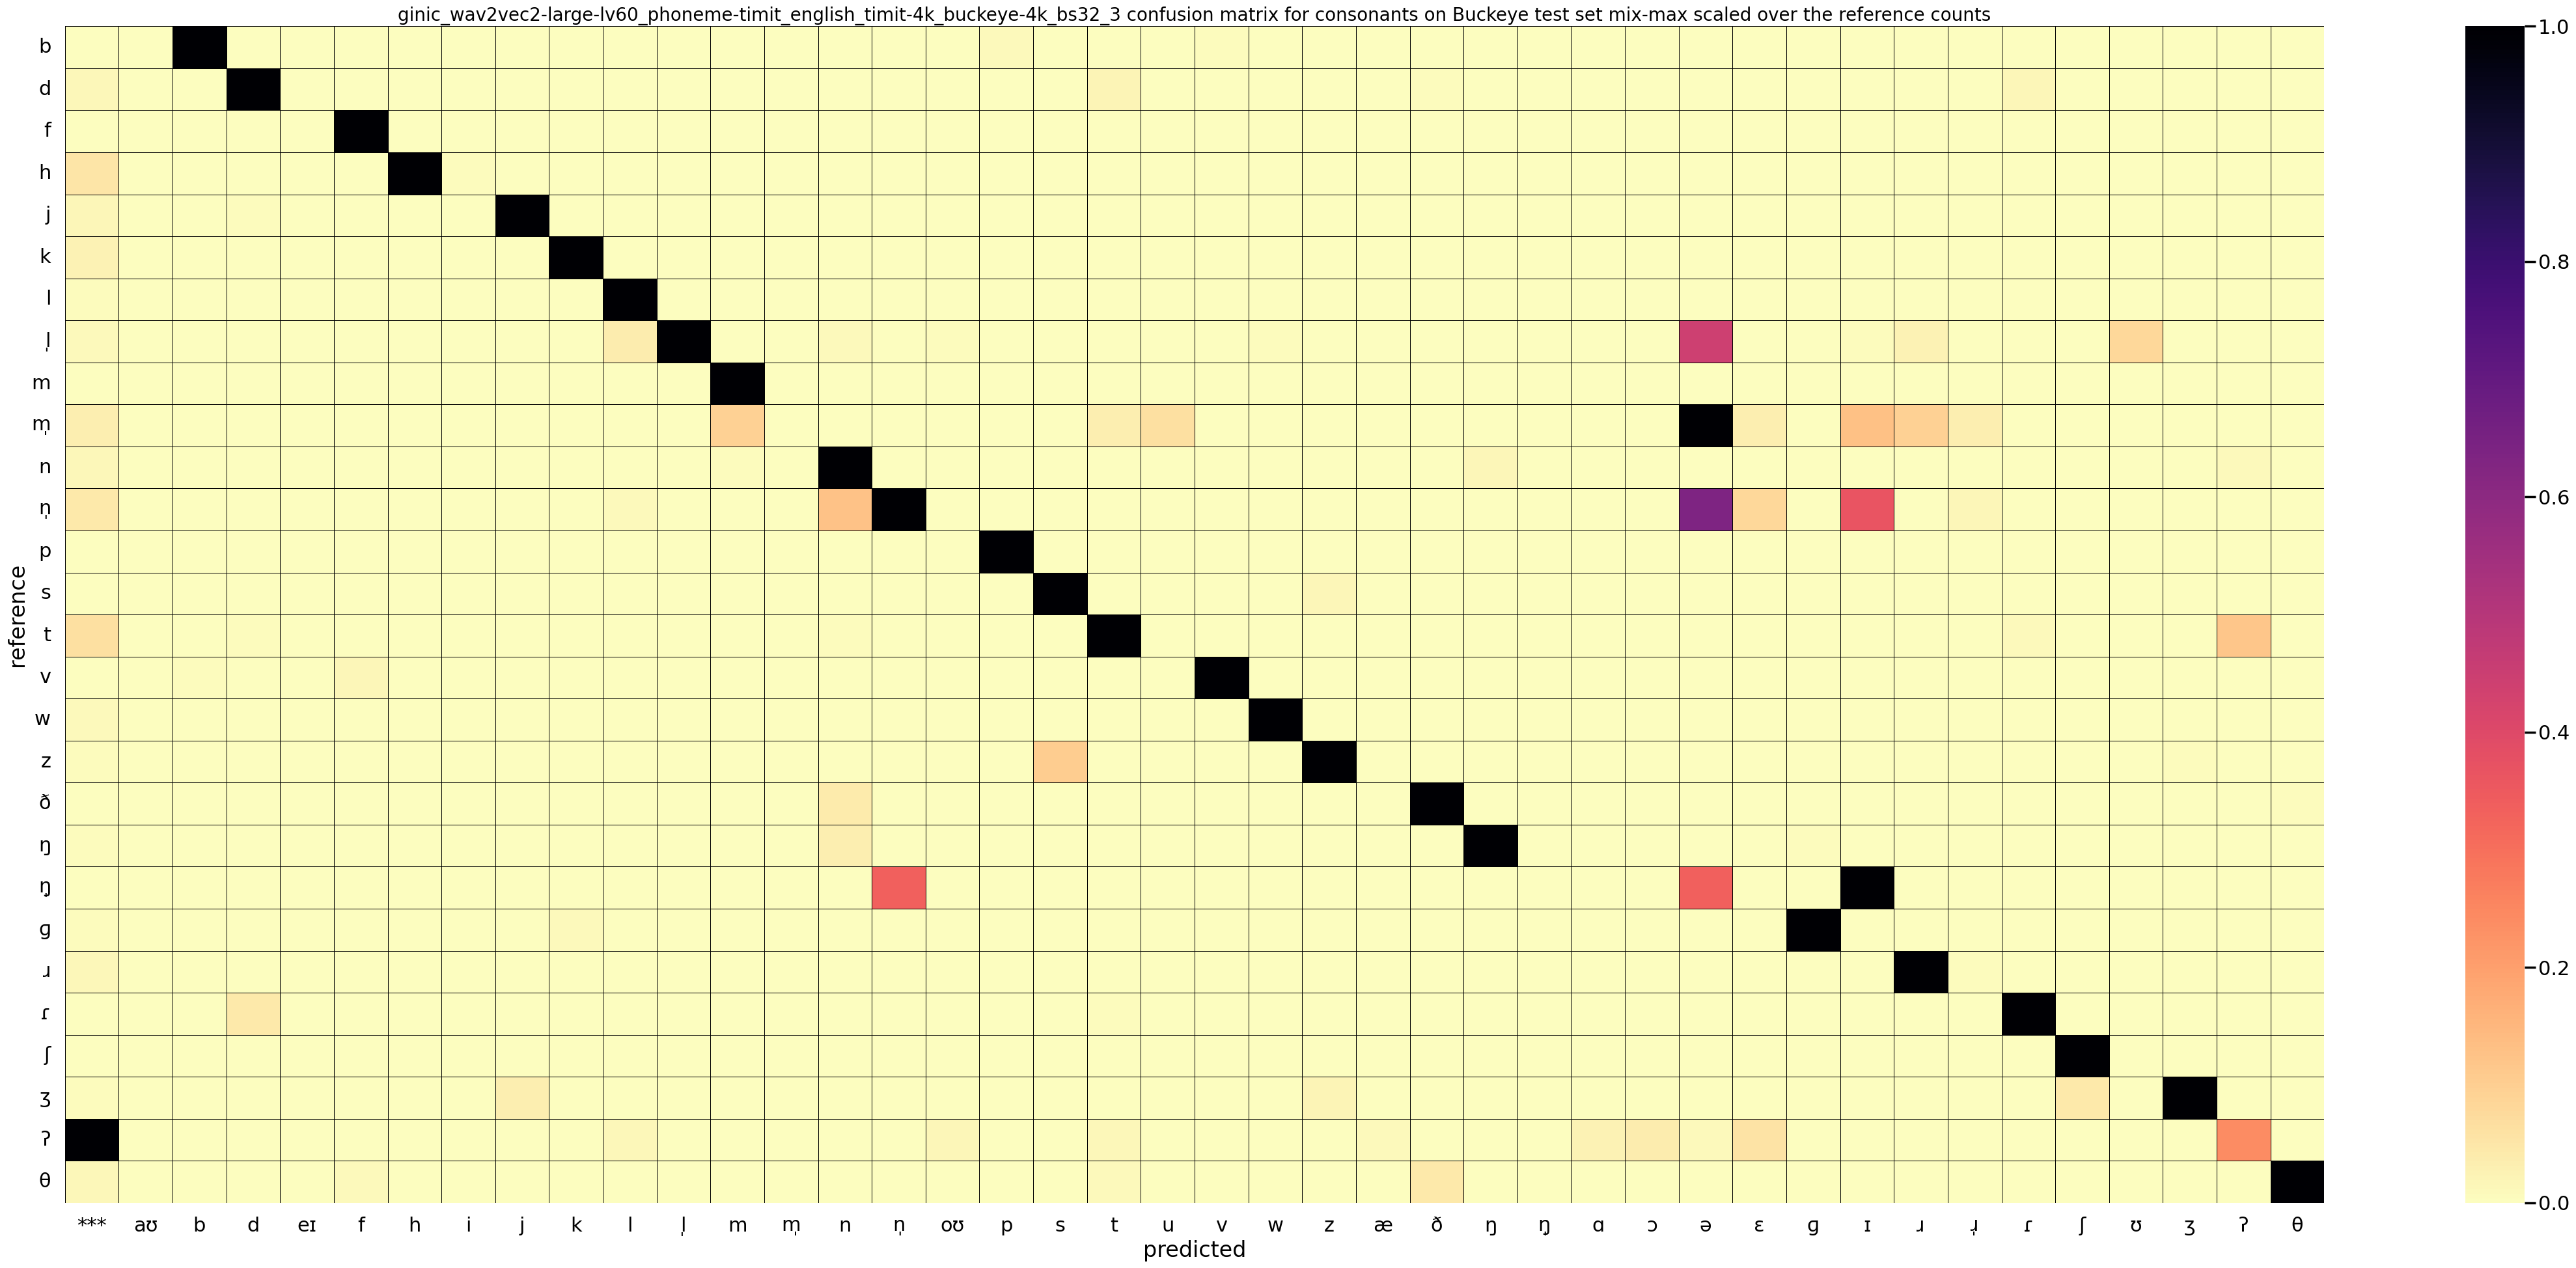

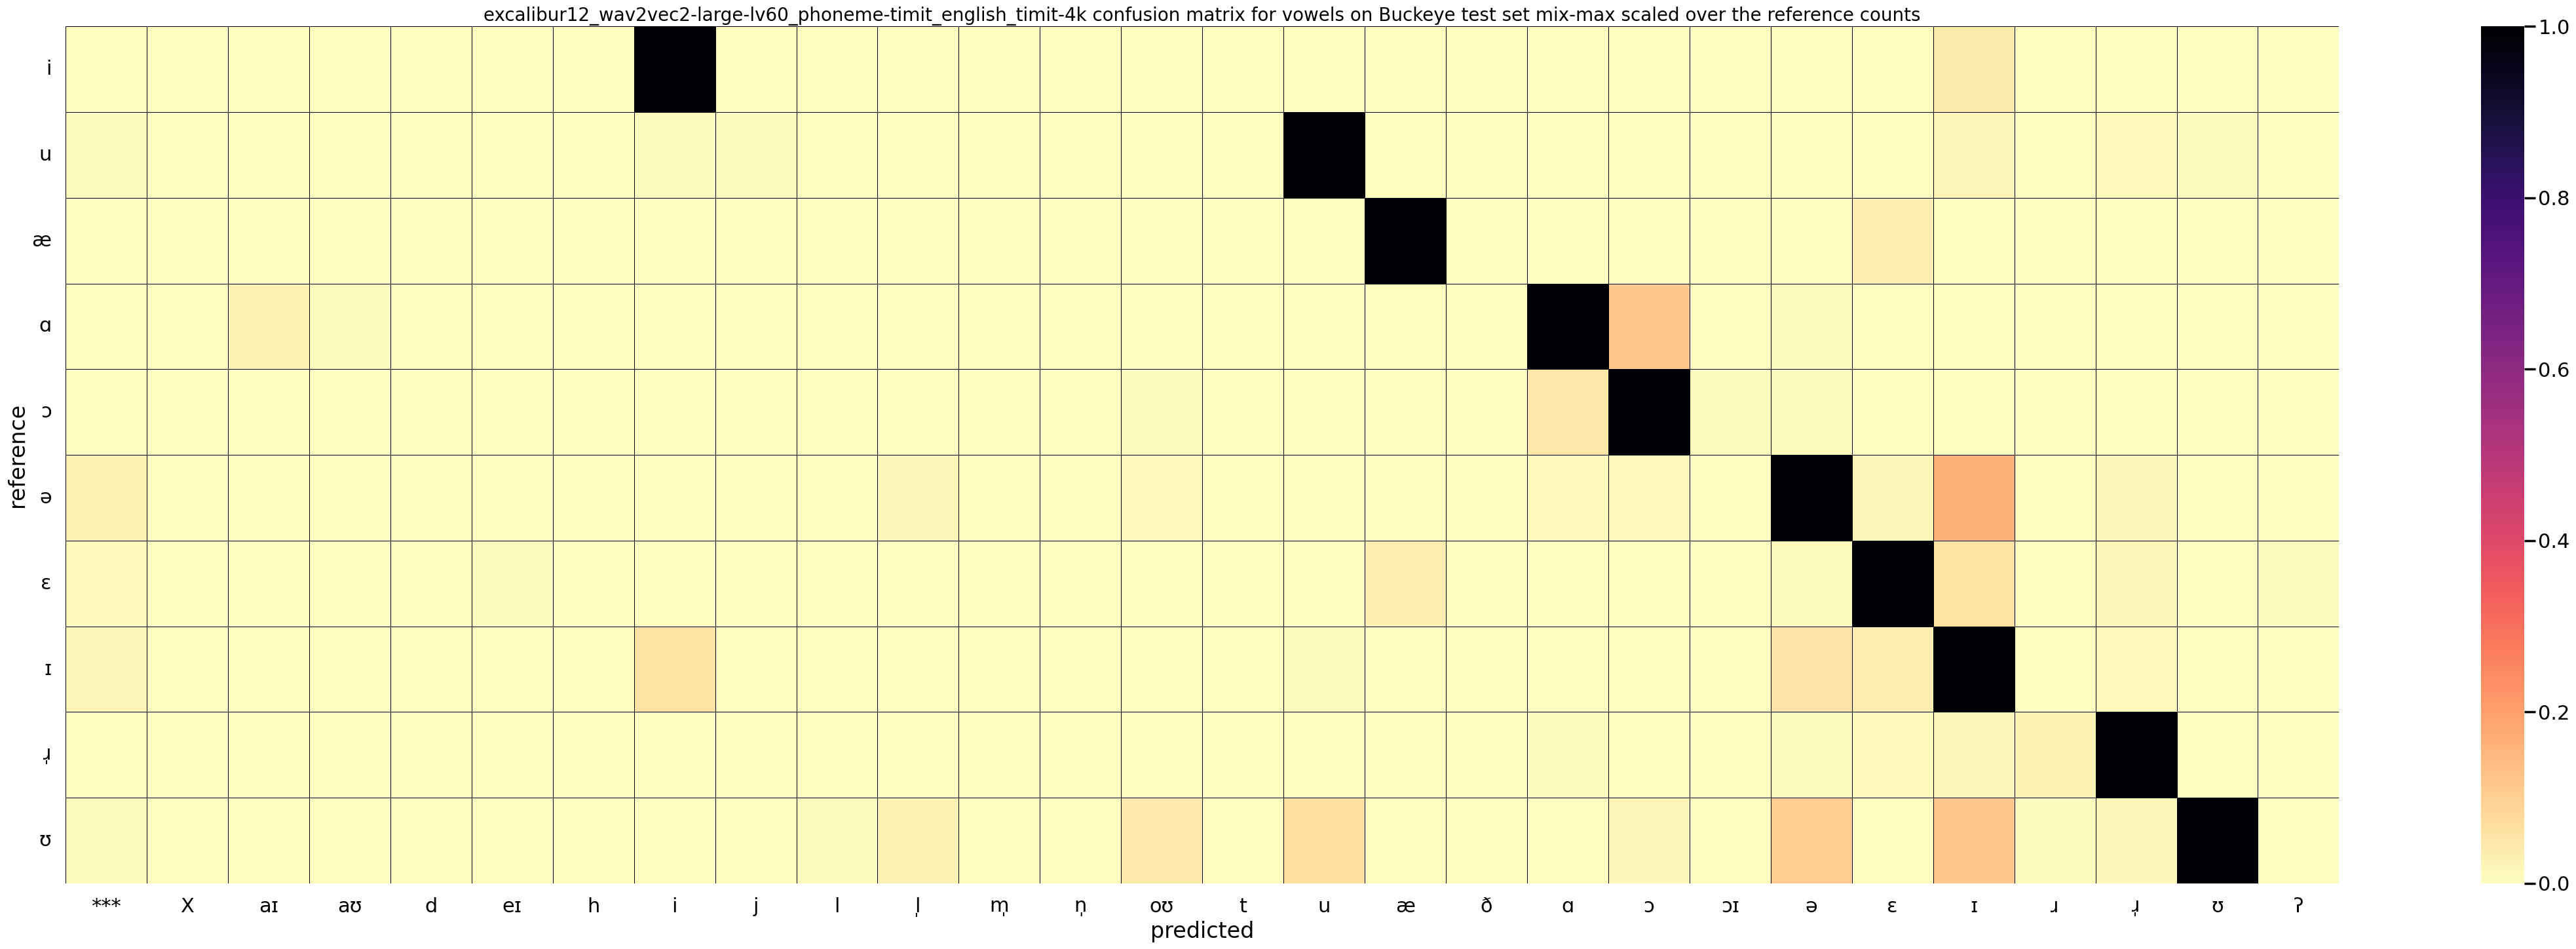

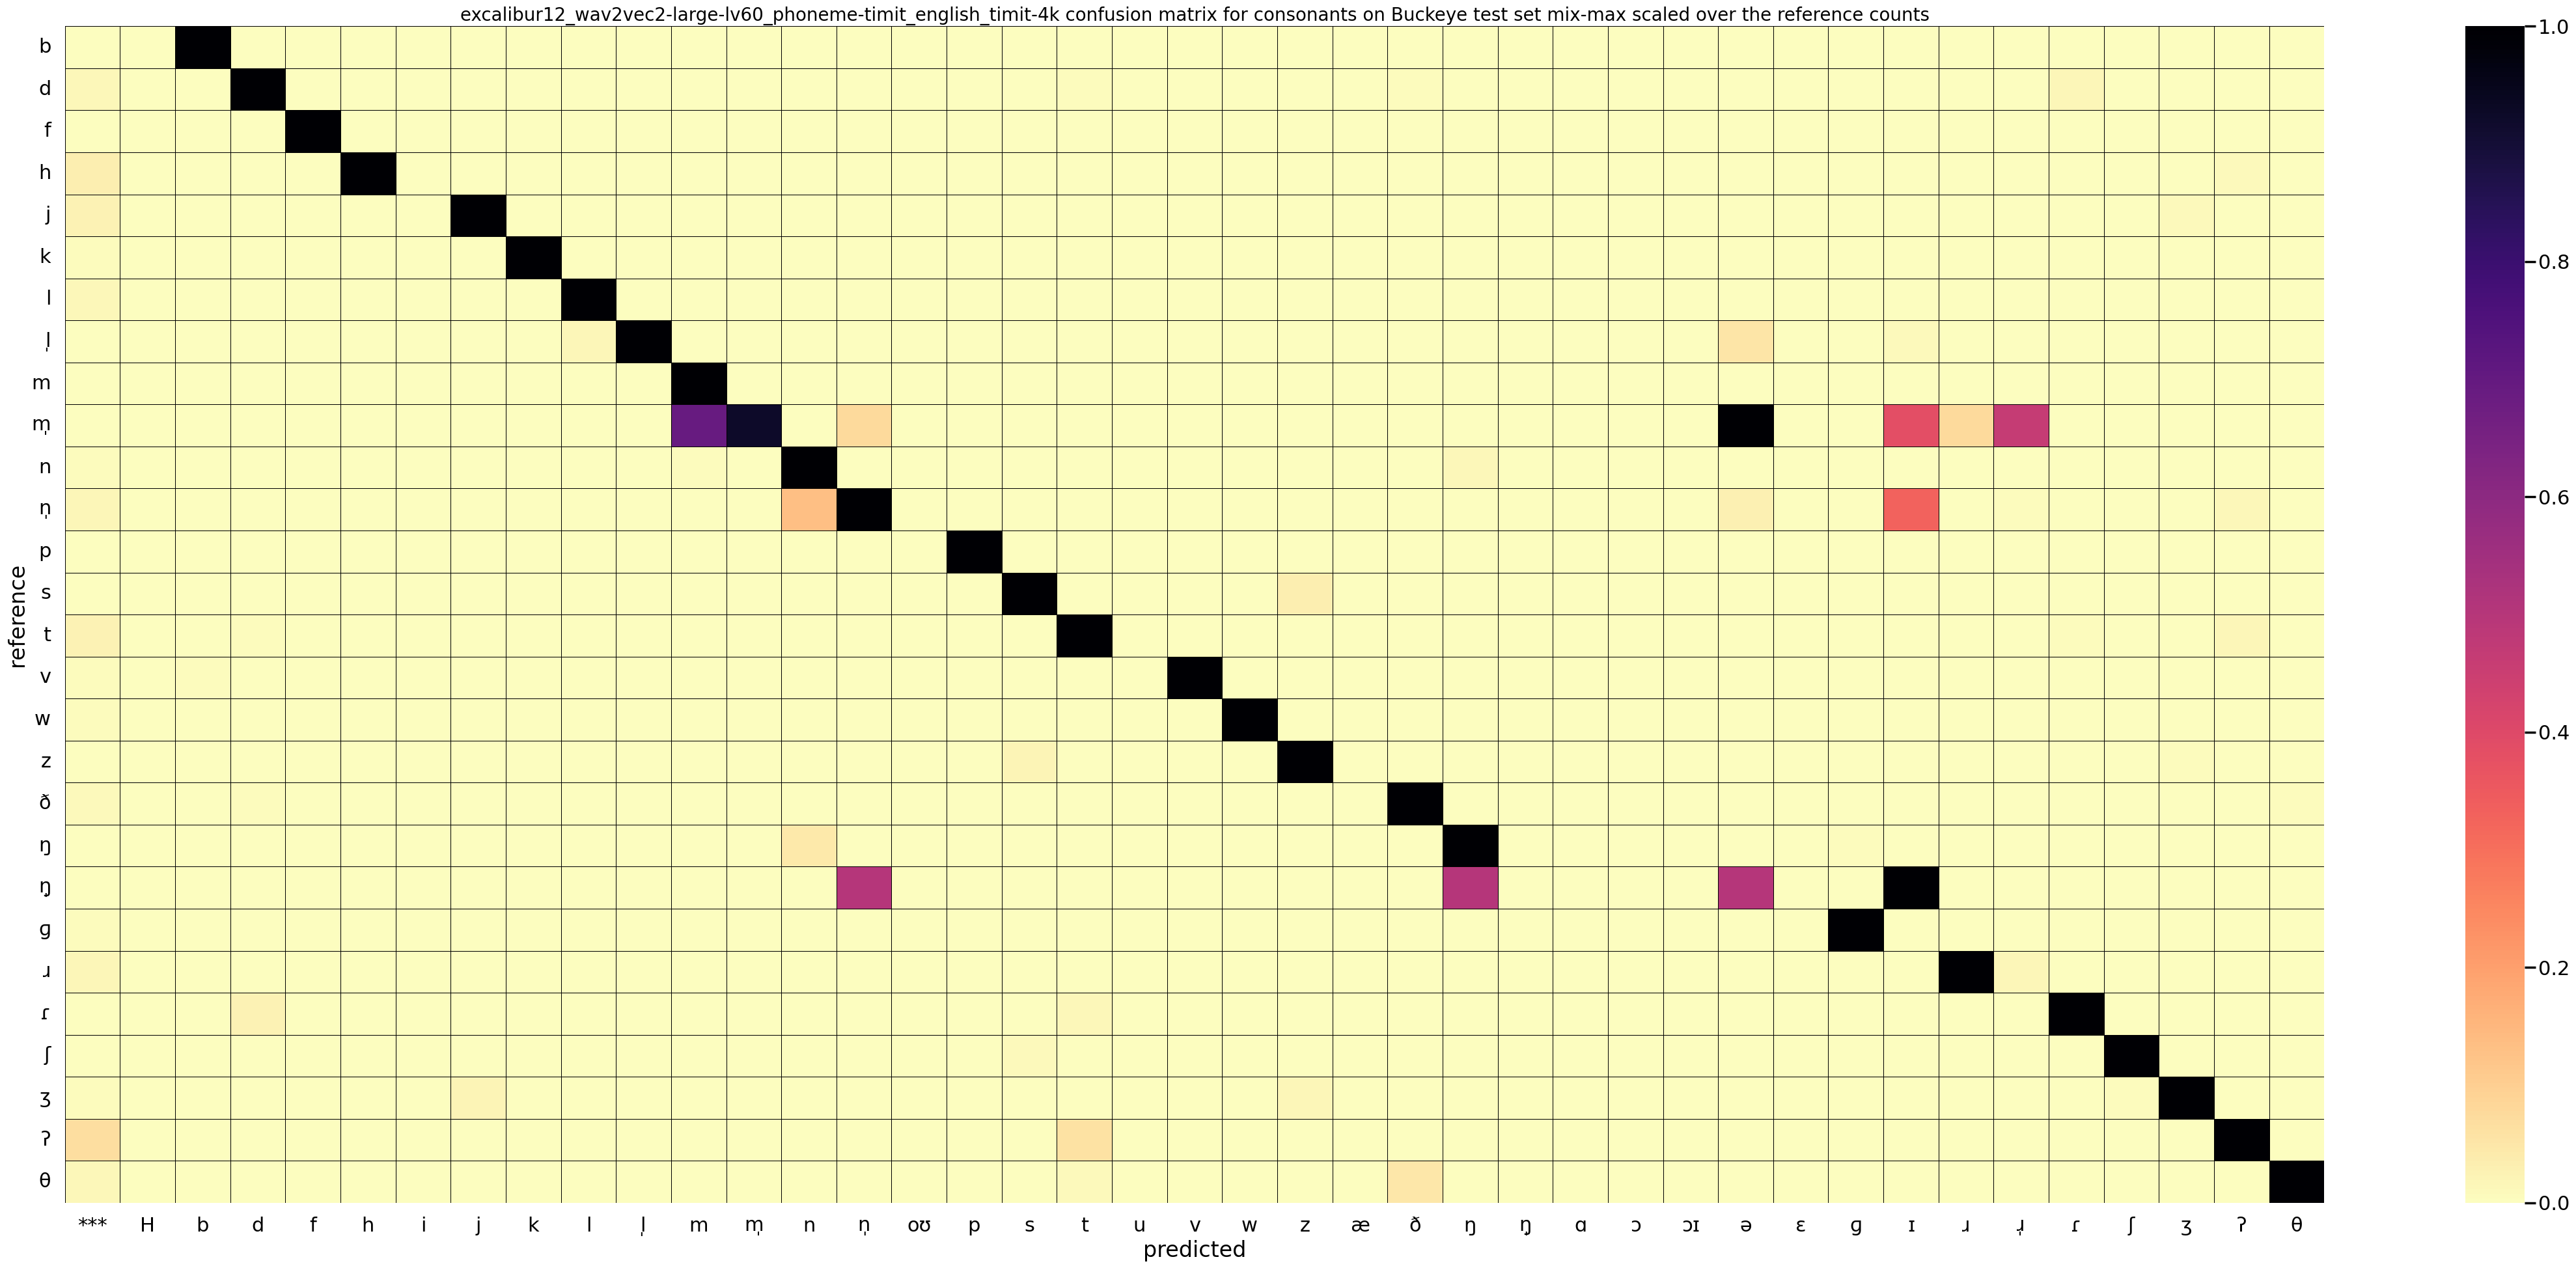

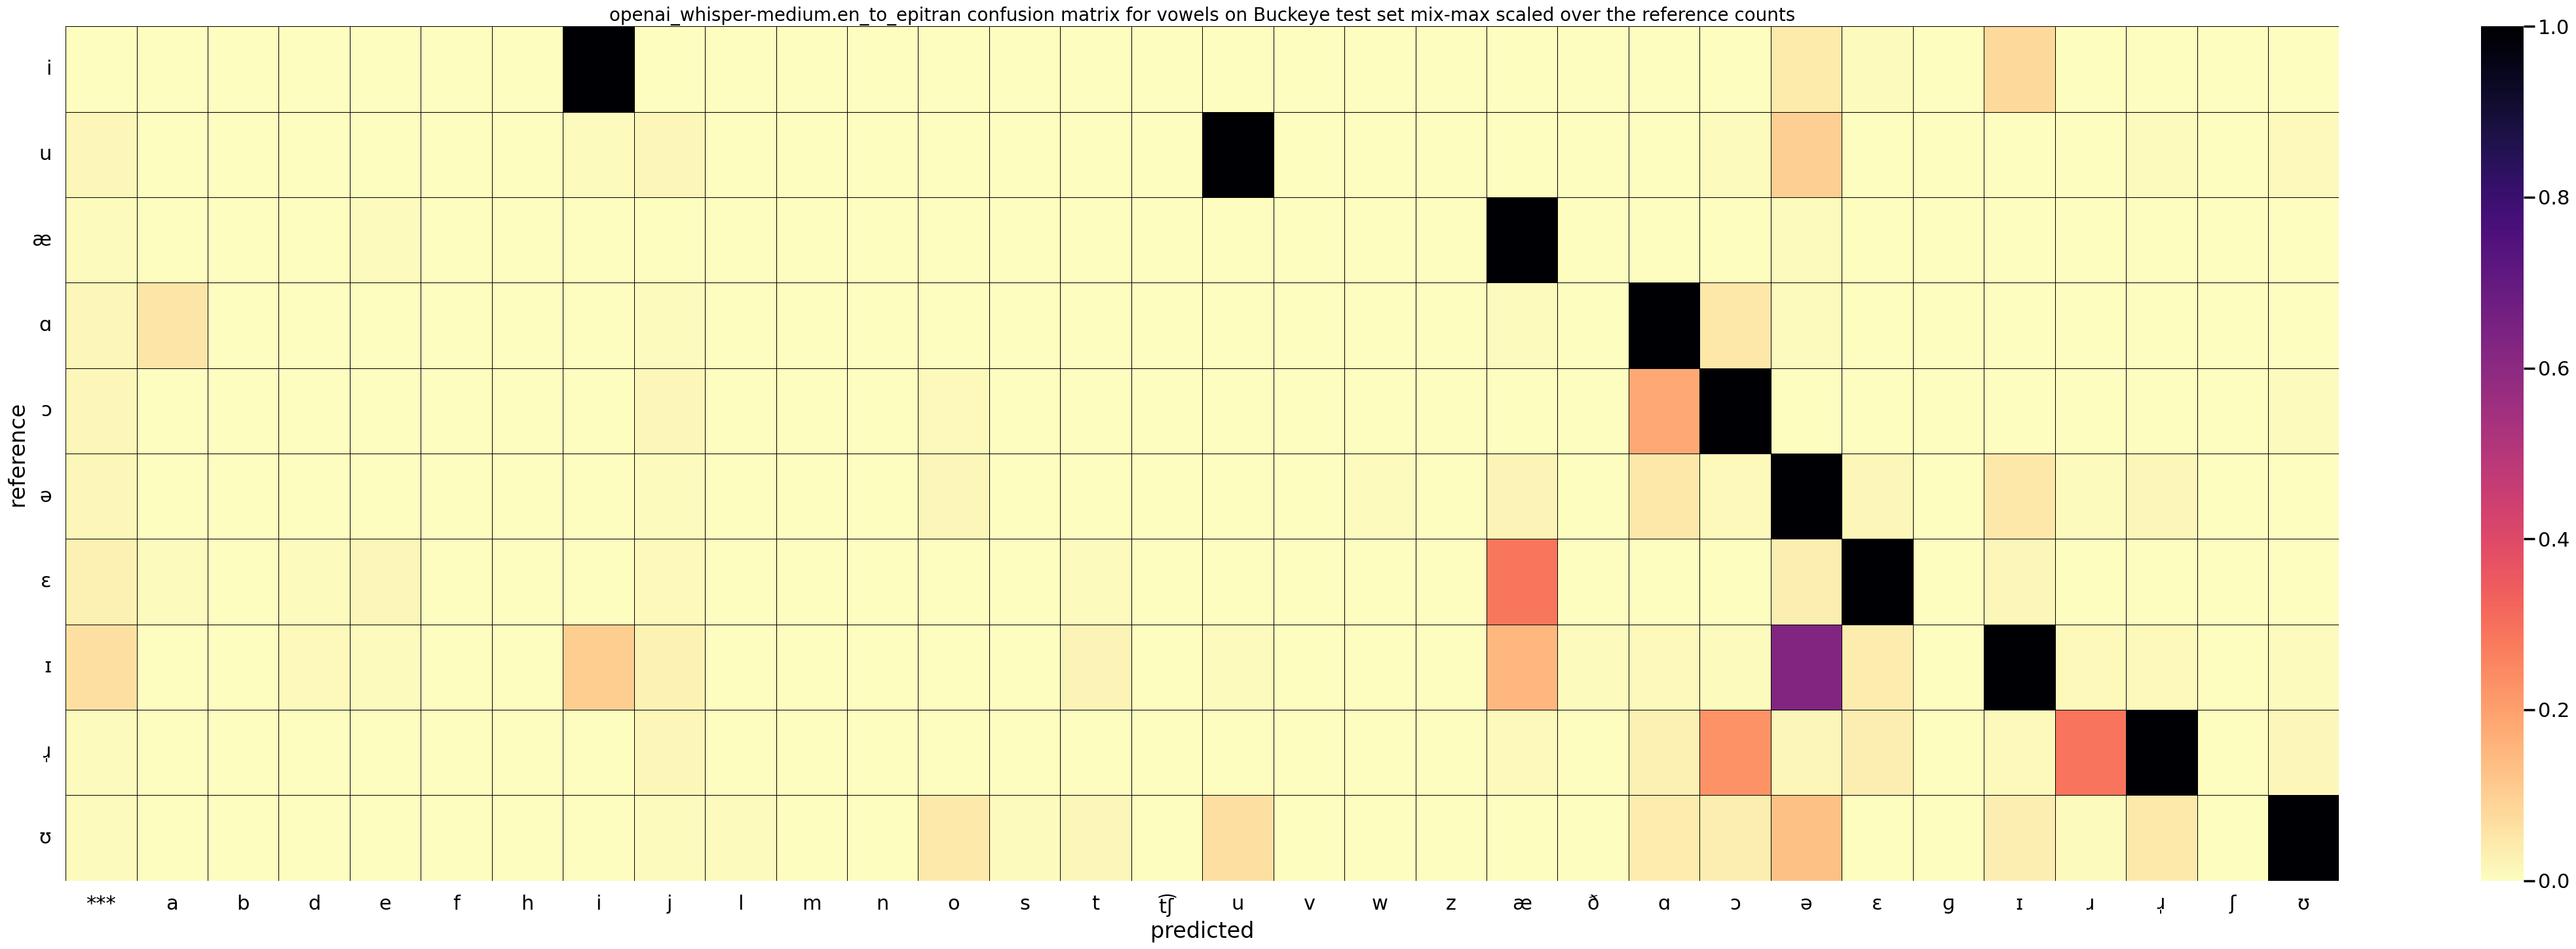

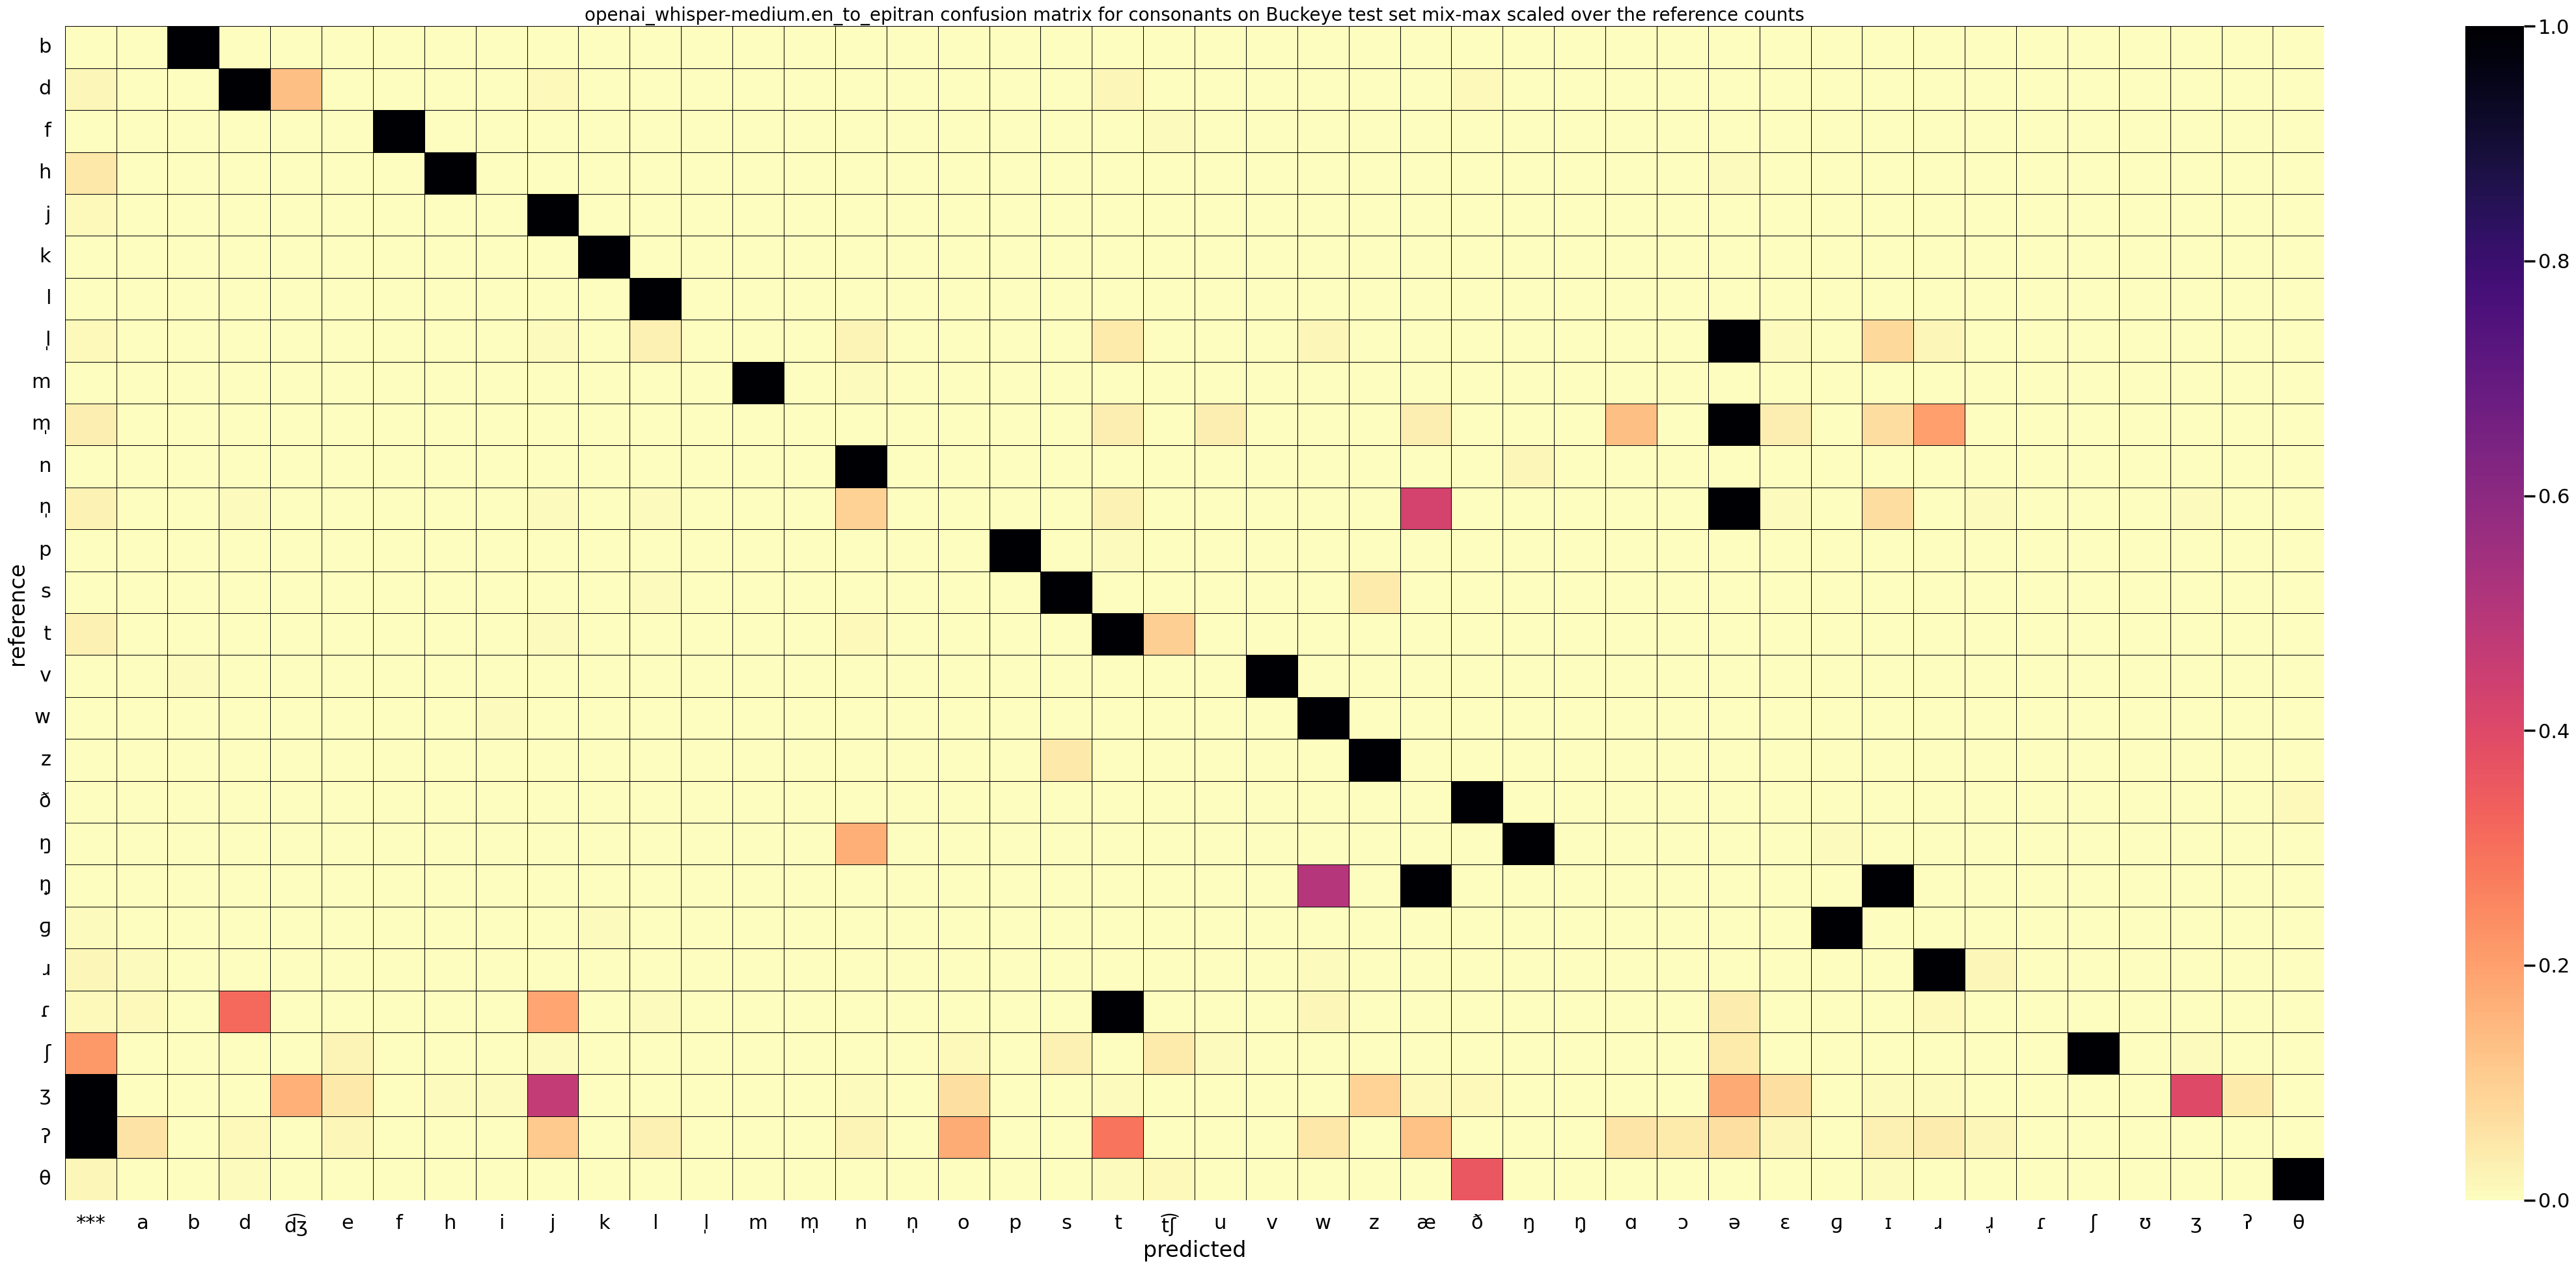

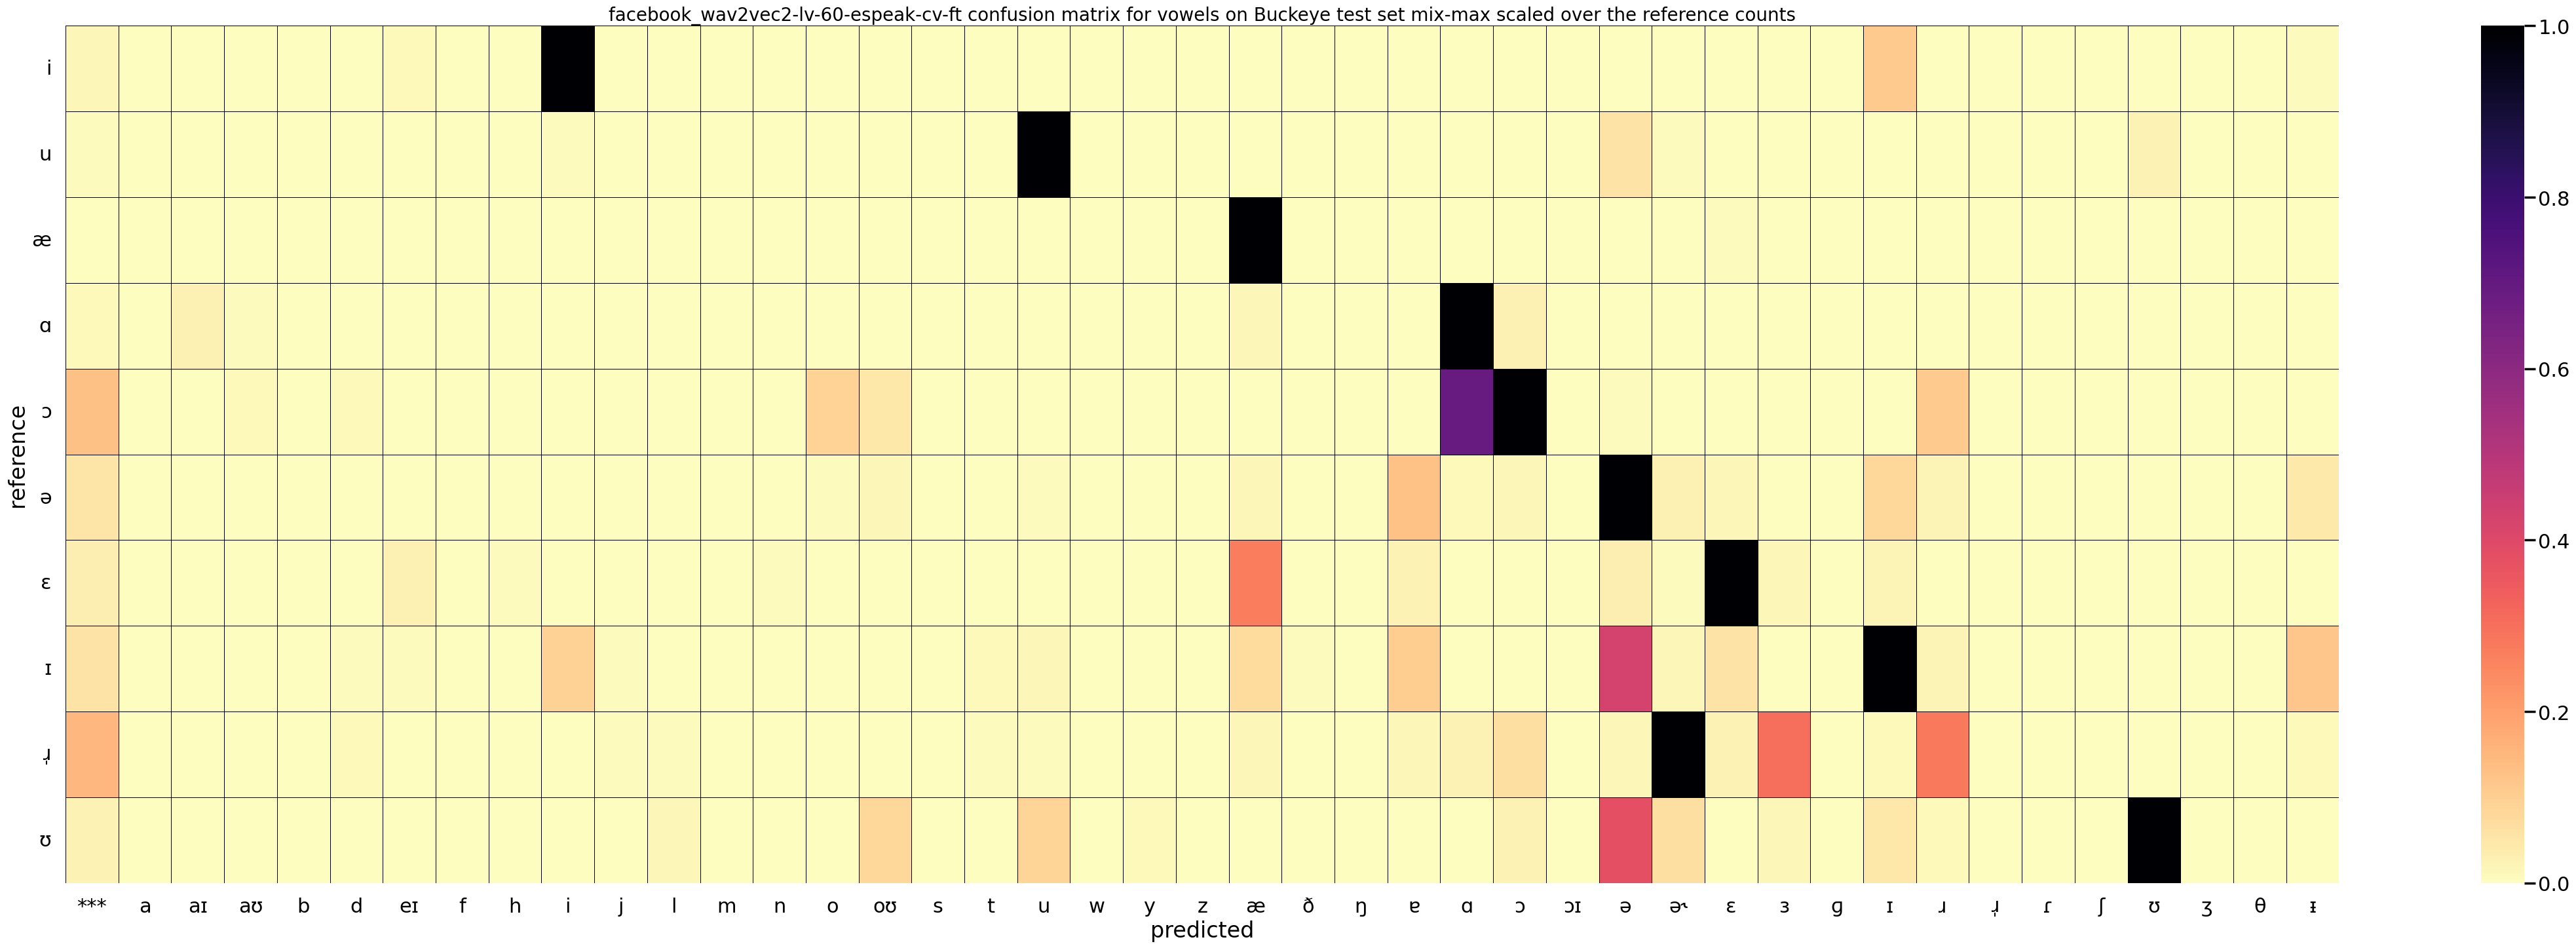

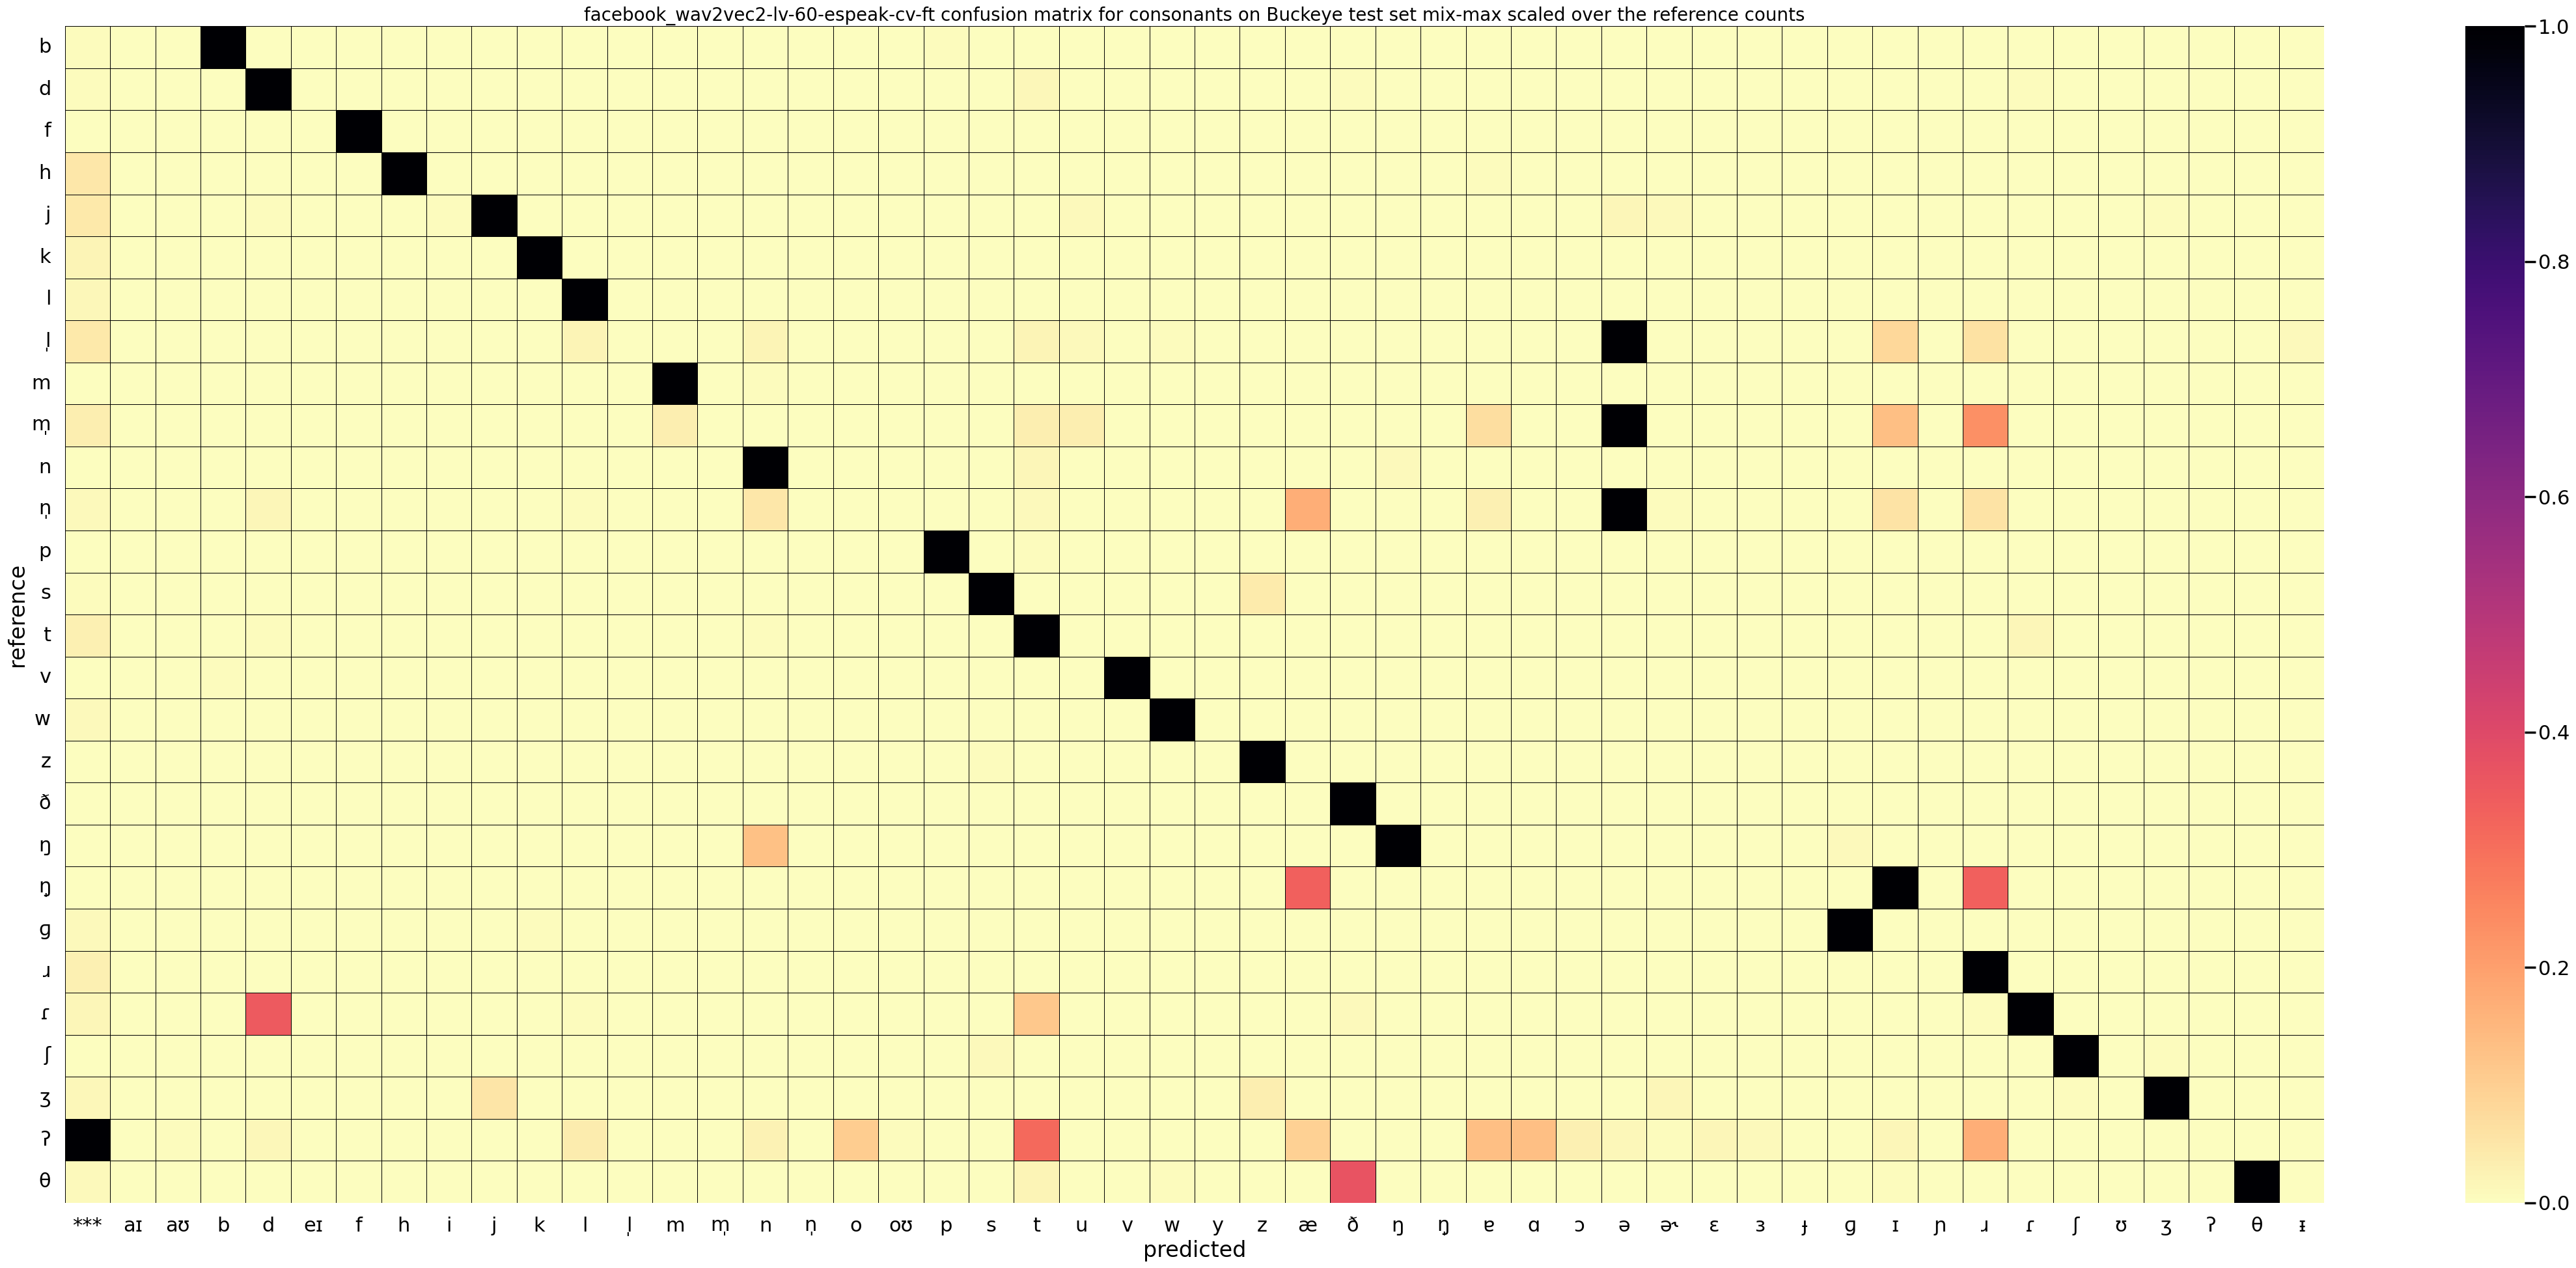

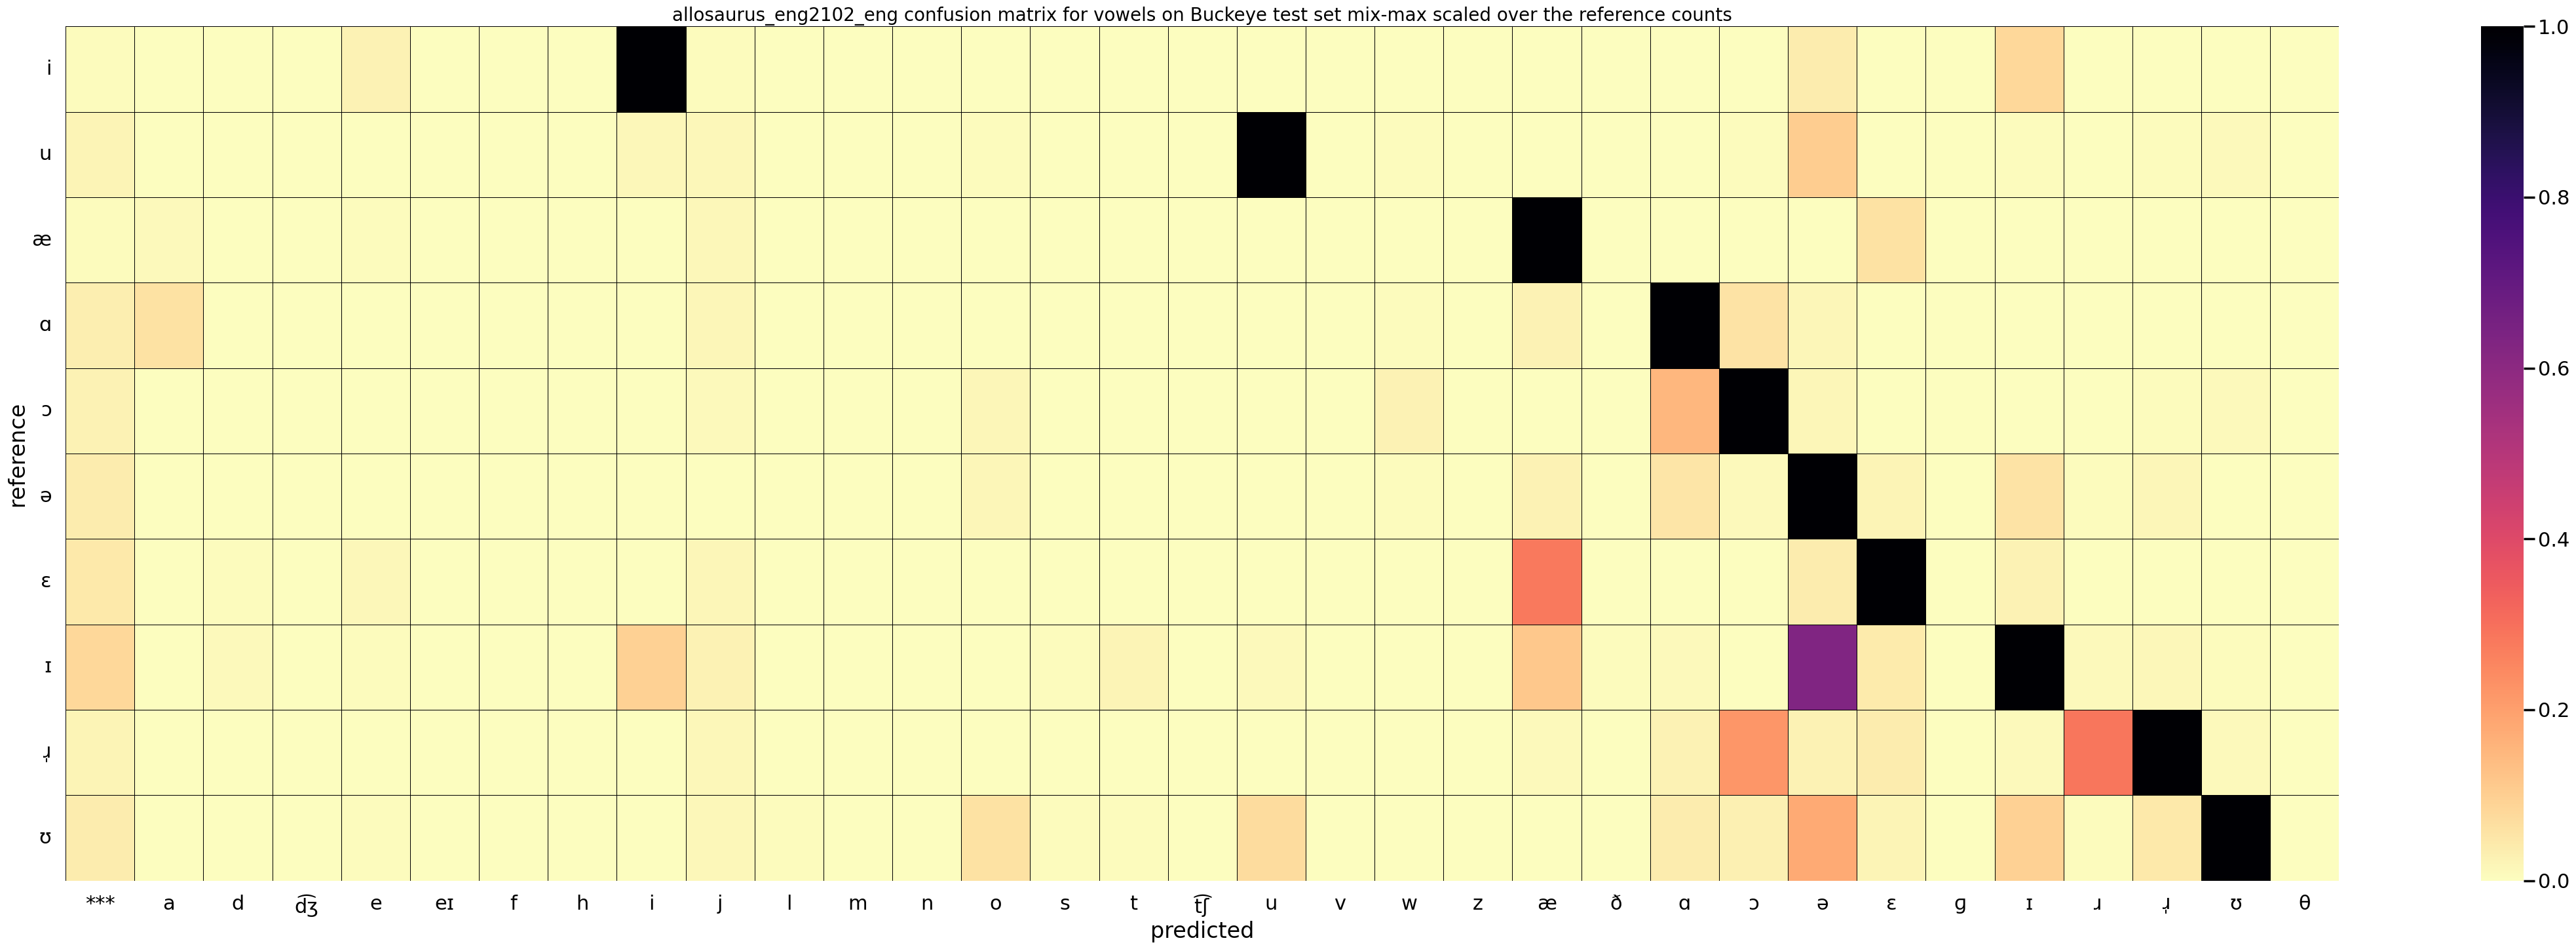

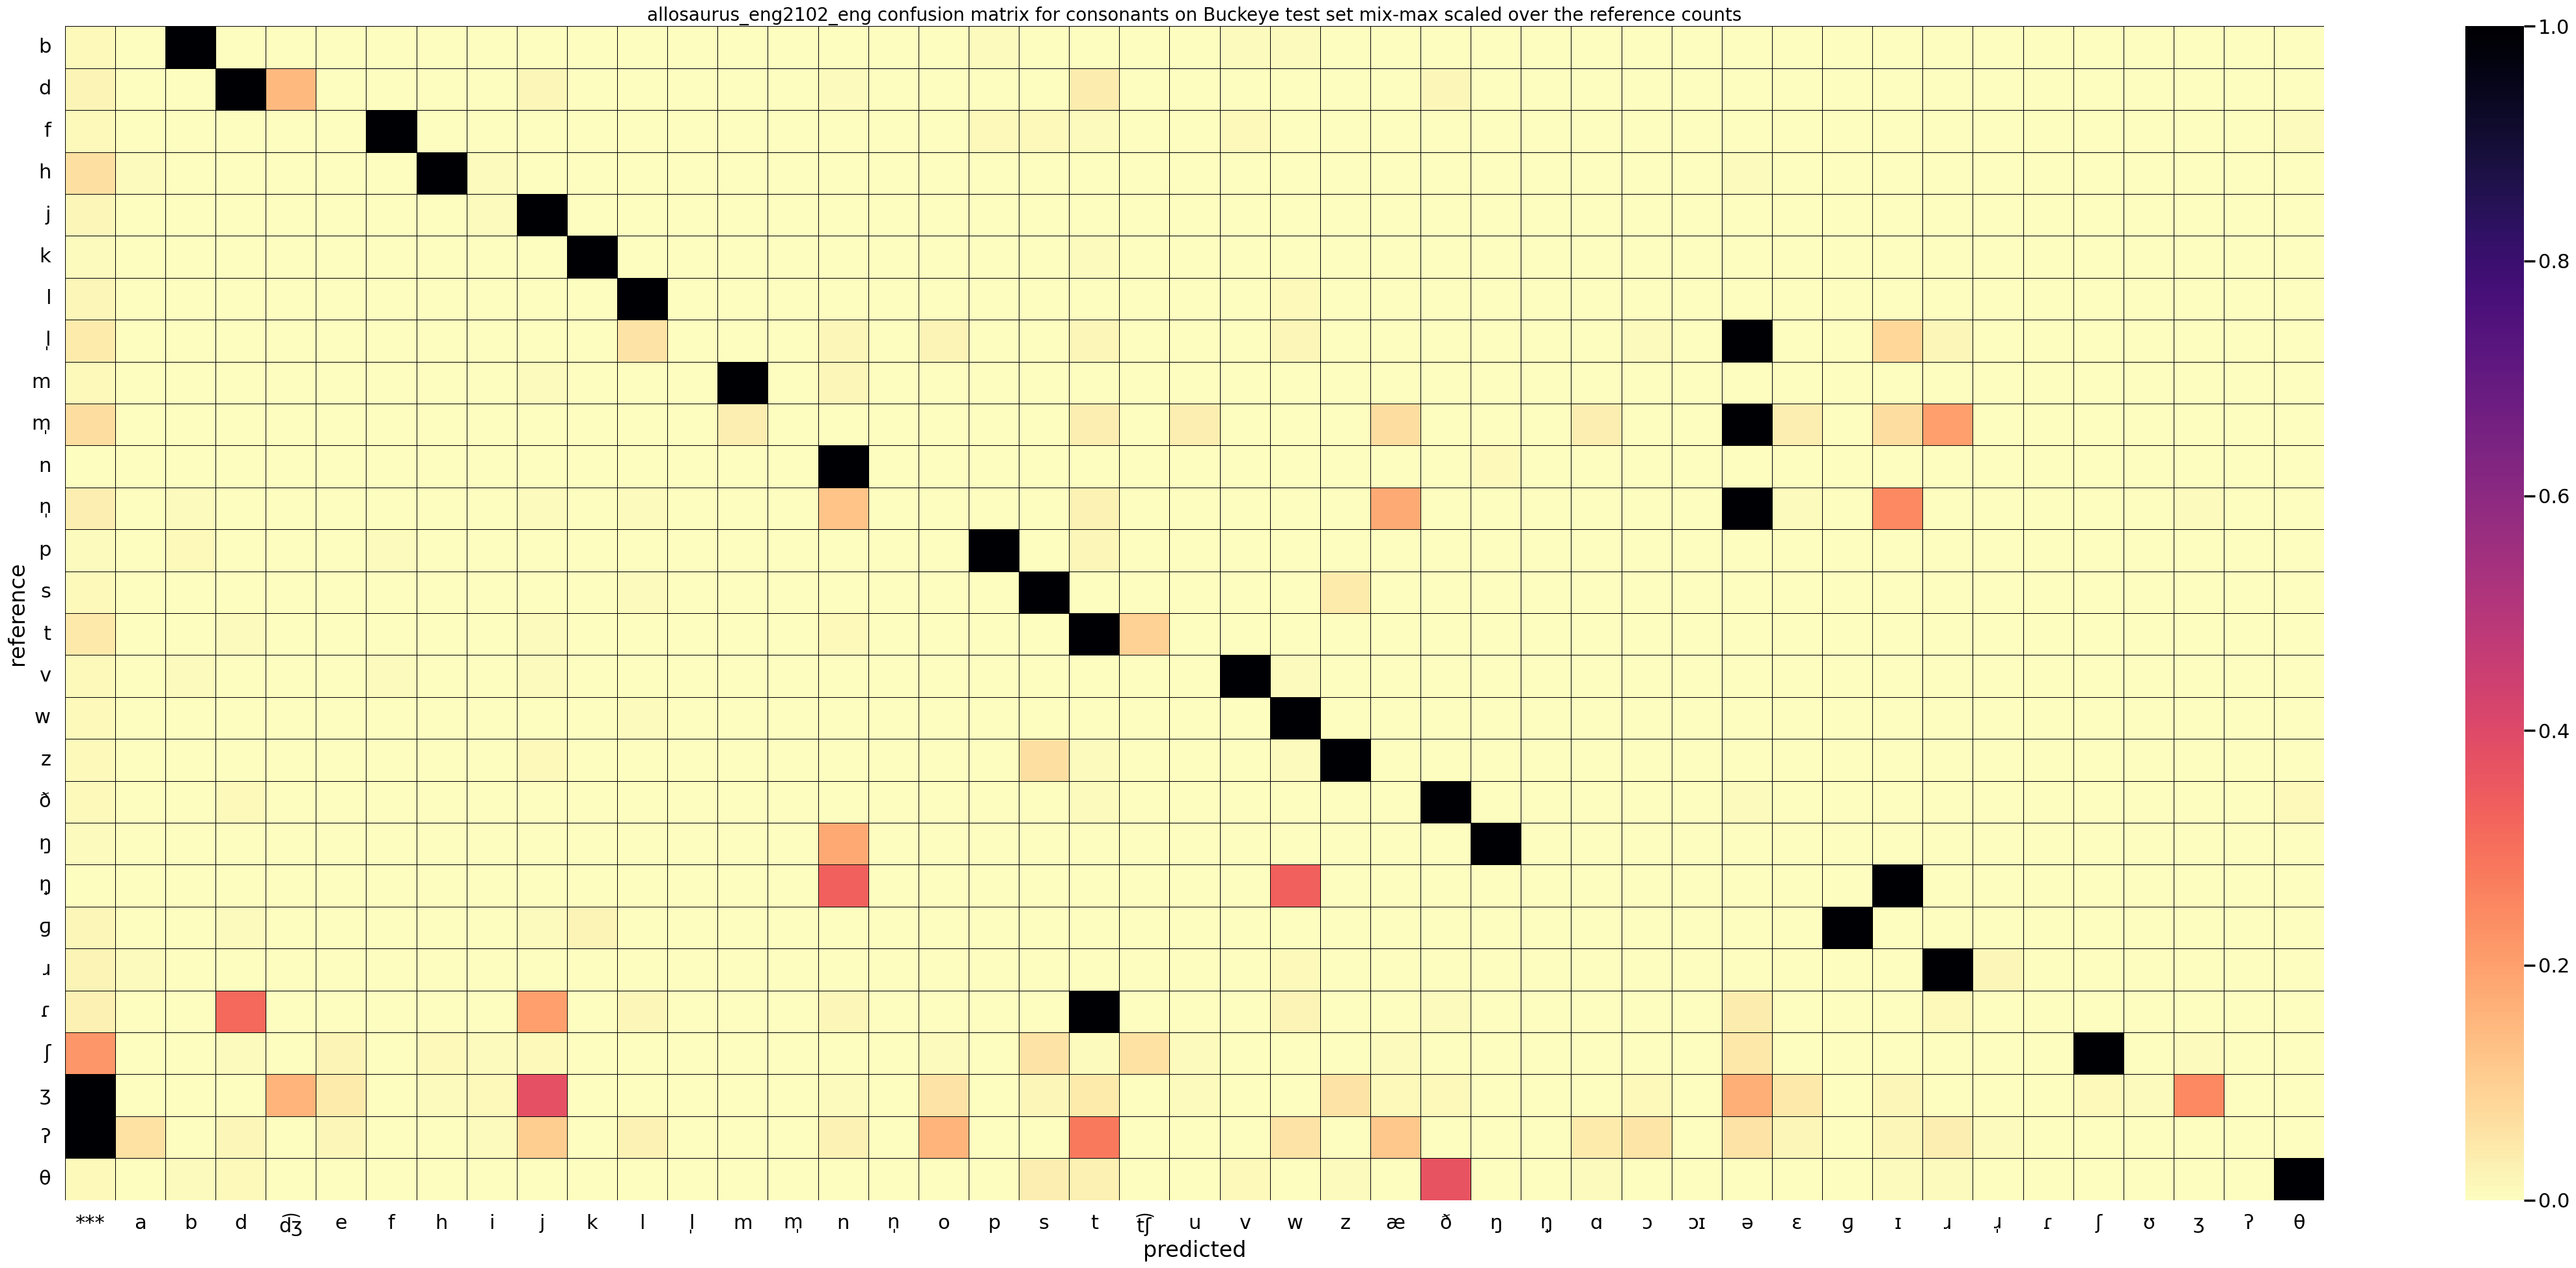

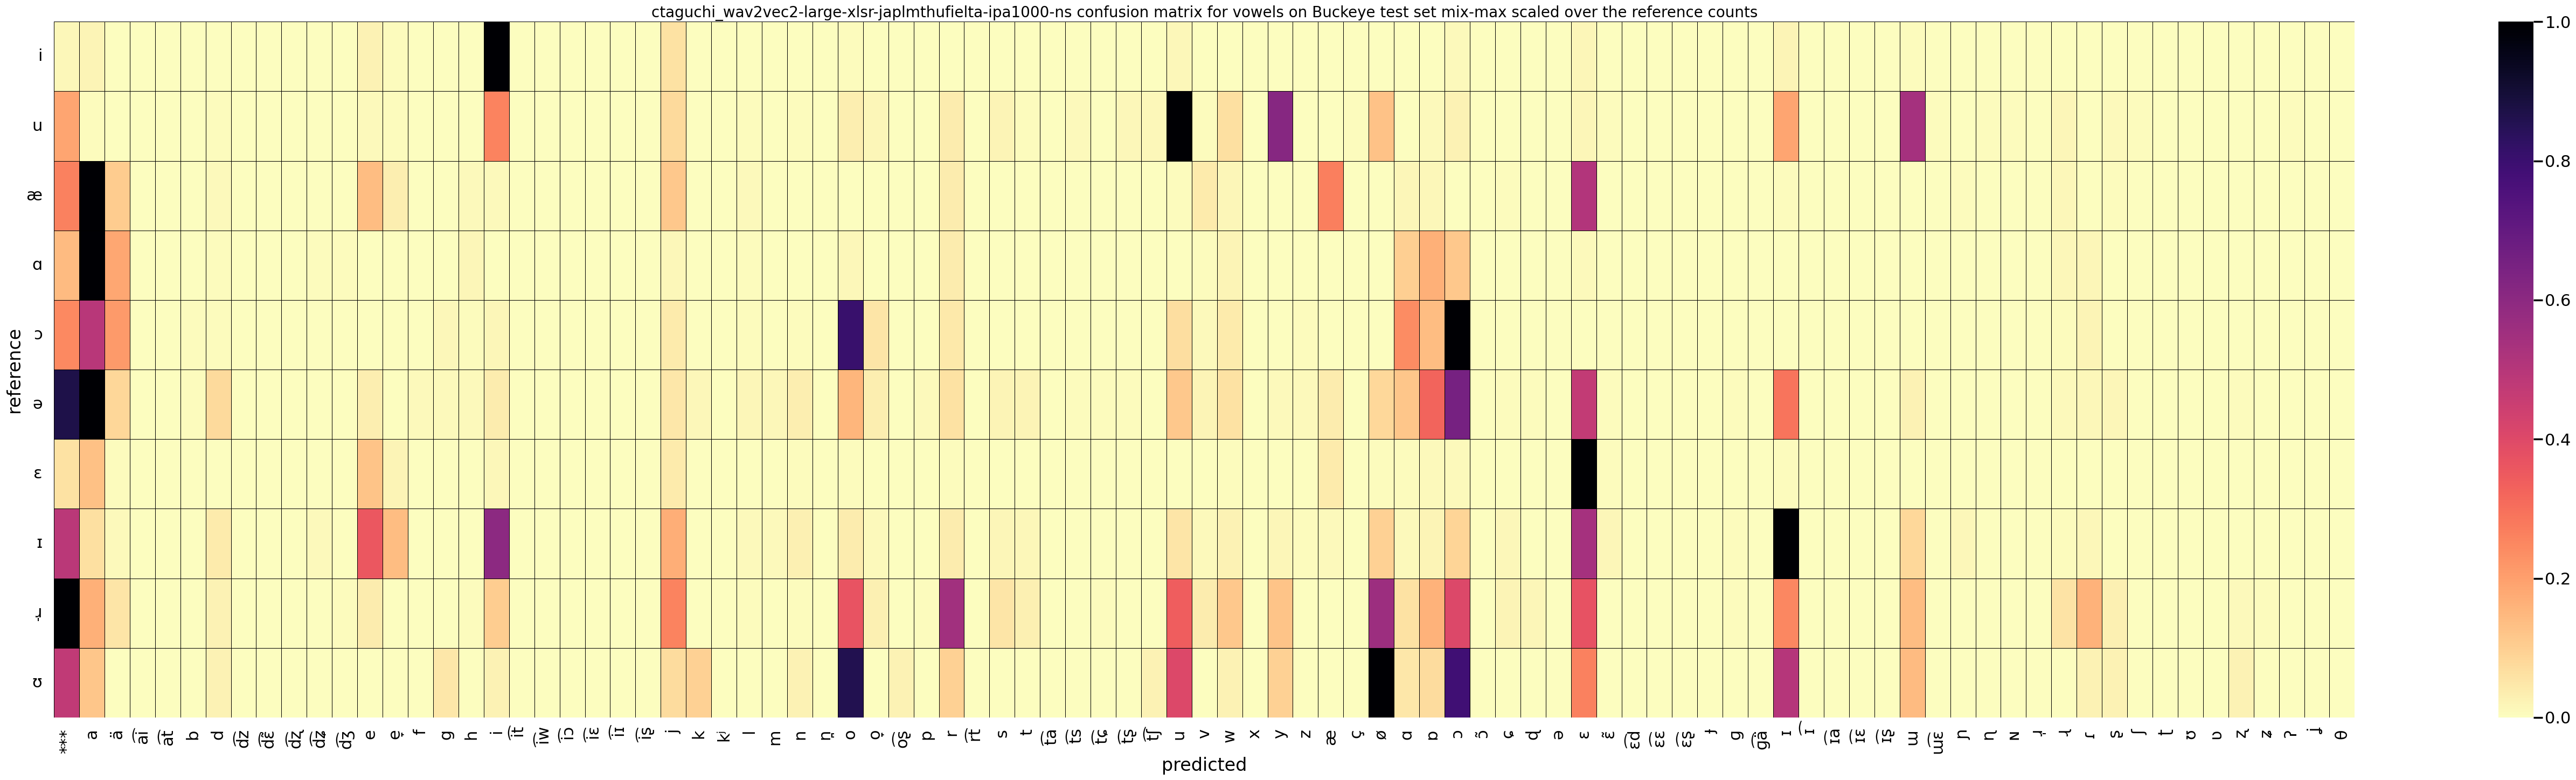

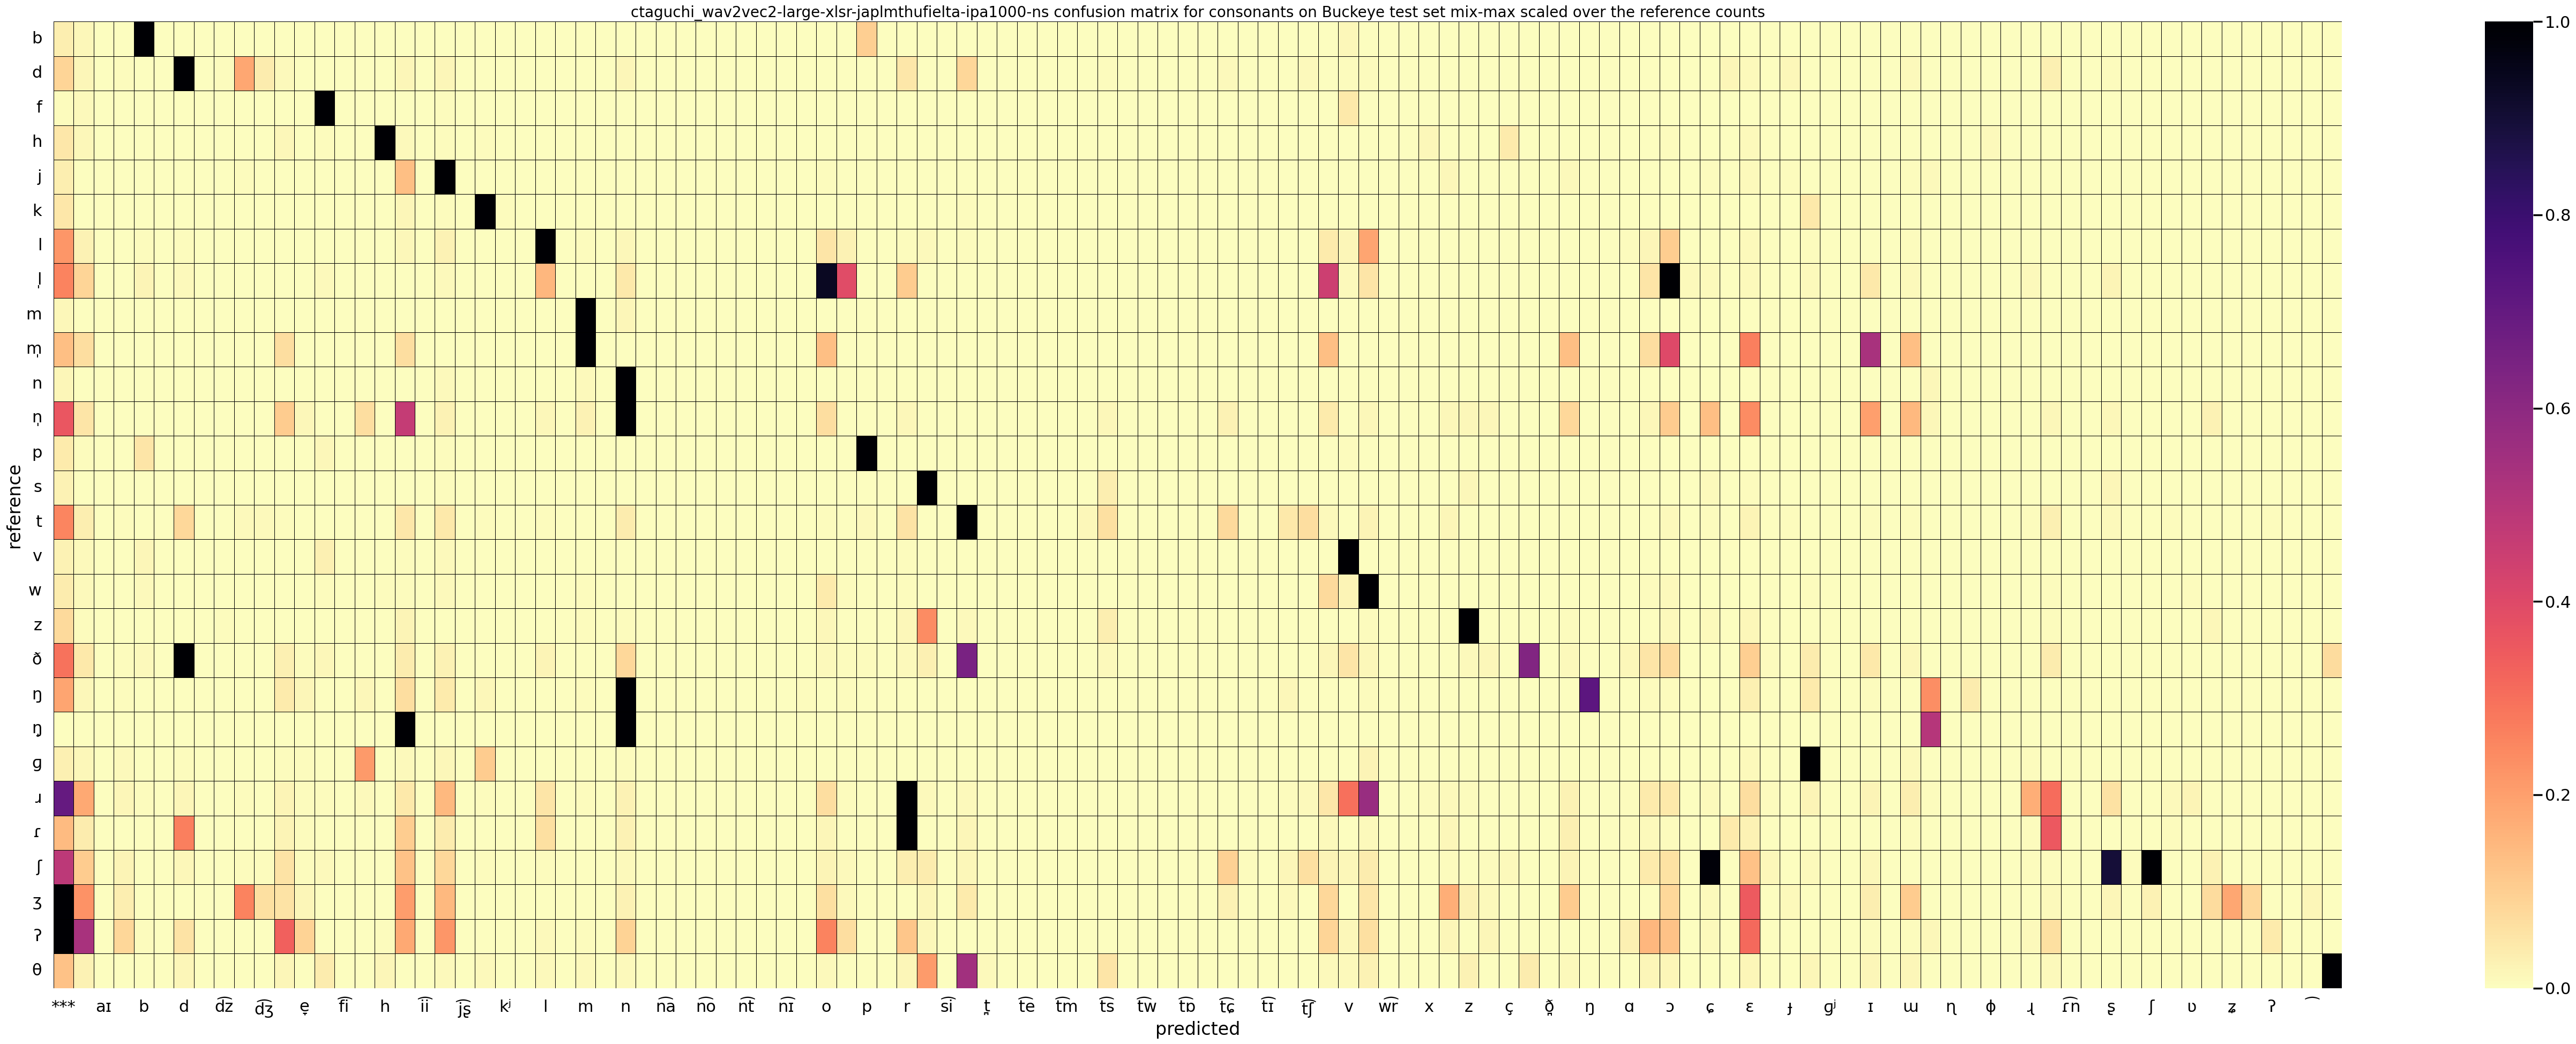

In [33]:
plt.clf()
for model_name in EVALUATOR.results_to_write.keys():
    print("Model name:", model_name)
    conf_matrix = EVALUATOR.get_token_confusion_matrix(model_name)
    for (label, restriction) in [("vowels", TIMIT_VOWELS), ("consonants",TIMIT_CONSONANTS)]:
        height=15
        if label=="consonants":
            height=20
        if model_name == "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns":
            figsize = (55, height)
        else:
            figsize = (45, height)
        multipa.visualization.plot_token_confusion_matrix(
            conf_matrix,
            f"{model_name} confusion matrix for {label} on Buckeye test set mix-max scaled over the reference counts",
            reference_keys=restriction,
            figsize=figsize,
            #annot=True,
            #fmt='.0f',
            cmap="magma_r",
            #cmap="Grays",
            linewidth=0.5,
            linecolor="black",
            fontsize=20,
            is_normalize_rows=True
        )
        plt.tight_layout()
        plt.savefig(VIZ_OUTPUT_DIR / f"timit_{model_name}_{label}_confusion_matrix.eps", format="eps")